In [ ]:
"""
Comprehensive Comparison of Three DPF Resampling Methods

This script compares:
1. DPF-Soft: Gumbel-Softmax with mixture resampling
2. DPF-OT: Optimal Transport (Sinkhorn) resampling  
3. DPF-RNN: RNN-learned resampling strategy

Metrics evaluated:
- Accuracy: RMSE, log-likelihood
- Efficiency: Runtime, memory
- Particle quality: ESS, diversity, entropy
- Method-specific: OT iterations, assignment entropy, etc.
"""

import numpy as np
import tensorflow as tf
import time
from scipy import stats
import matplotlib.pyplot as plt
import json
import os

# Import the three DPF implementations
import sys
# Add parent directory to path
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, os.path.join(parent_dir, 'models'))
sys.path.insert(0, os.path.join(parent_dir, 'simulator'))

from DPF_soft_resampling import DifferentiableParticleFilter
from DPF_OT_resampling import DPF_OT
from DPF_RNN_resampling import DifferentiableParticleFilterRNN
from simulator_LGSSM import simulate_lgssm

print("✓ All modules imported successfully!")


# =================================================================
# Synthetic Data Generation
# =================================================================

def generate_linear_gaussian_data(T, a=0.9, sigma_q=0.5, sigma_r=0.7, x0=0.0, seed=None):
    """Generate synthetic data from linear Gaussian state-space model.

    Implements:
    - State: x_t = a * x_{t-1} + q_noise, q_noise ~ N(0, sigma_q^2)
    - Observation: y_t = x_t + r_noise, r_noise ~ N(0, sigma_r^2)

    Args:
        T (int): Number of timesteps.
        a (float, optional): State transition coefficient. Defaults to 0.9.
        sigma_q (float, optional): Process noise std deviation. Defaults to 0.5.
        sigma_r (float, optional): Measurement noise std deviation. Defaults to 0.7.
        x0 (float, optional): Initial state value (unused, drawn from prior). Defaults to 0.0.
        seed (int, optional): Random seed. Defaults to None.

    Returns:
        tuple: (x, y) where:
            - x (np.ndarray): Latent states of shape (T+1, 1).
            - y (np.ndarray): Observations of shape (T, 1).
    """
    # Define system matrices for LGSSM simulator
    # State transition: x_{t+1} = A * x_t + B * v_t, v_t ~ N(0, I)
    A = np.array([[a]], dtype=np.float64)
    B = np.array([[sigma_q]], dtype=np.float64)
    
    # Observation: y_t = C * x_t + D * w_t, w_t ~ N(0, I)
    C = np.array([[1.0]], dtype=np.float64)
    D = np.array([[sigma_r]], dtype=np.float64)
    
    # Initial state covariance
    Sigma = np.array([[1.0]], dtype=np.float64)
    
    # Simulate data
    result = simulate_lgssm(A, B, C, D, Sigma, N=T, seed=seed, burn_in=0)
    
    # Convert to the expected format
    # result.X is (T, 1), result.Y is (T, 1)
    # We need x to be (T+1, 1) to include x_0
    
    # Create x_0 ~ N(0, Sigma)
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()
    
    x0_sampled = rng.multivariate_normal(mean=np.array([0.0]), cov=Sigma)
    
    # Concatenate x_0 with the simulated states
    x = np.vstack([x0_sampled.reshape(1, 1), result.X]).astype(np.float32)
    y = result.Y.astype(np.float32)
    
    return x, y



# =================================================================
# Transition and Observation Functions
# =================================================================

def linear_gaussian_transition(x_prev, params):
    """Linear Gaussian transition for DPF-Soft and DPF-RNN (batched).

    Args:
        x_prev (tf.Tensor): Previous states of shape (B, N, state_dim).
        params (dict): Parameters containing 'a' and 'sigma_q'.

    Returns:
        tf.Tensor: New states of shape (B, N, state_dim).
    """
    a = params.get("a", 0.9)
    sigma_q = params.get("sigma_q", 0.5)
    
    a = tf.convert_to_tensor(a, dtype=tf.float32)
    sigma_q = tf.convert_to_tensor(sigma_q, dtype=tf.float32)
    
    a = tf.reshape(a, (1, 1, 1))
    sigma_q = tf.reshape(sigma_q, (1, 1, 1))
    
    eps = tf.random.normal(tf.shape(x_prev), dtype=tf.float32)
    x_new = a * x_prev + sigma_q * eps
    return x_new


def linear_gaussian_log_likelihood(x, y, params):
    """Linear Gaussian observation model (batched).

    Args:
        x (tf.Tensor): States of shape (B, N, state_dim).
        y (tf.Tensor): Observations of shape (B, obs_dim).
        params (dict): Parameters containing 'sigma_r'.

    Returns:
        tf.Tensor: Log-likelihoods of shape (B, N).
    """
    sigma_r = params.get("sigma_r", 0.5)
    sigma_r = tf.convert_to_tensor(sigma_r, dtype=tf.float32)
    
    y = tf.expand_dims(y, axis=1)  # (B,1,1)
    y = tf.broadcast_to(y, tf.shape(x))  # (B,N,1)
    
    diff = y - x
    var = sigma_r ** 2
    log_norm_const = -0.5 * tf.math.log(2.0 * np.pi * var)
    log_lik = log_norm_const - 0.5 * (diff ** 2) / var  # (B,N,1)
    return tf.squeeze(log_lik, axis=-1)  # (B,N)


def linear_gaussian_transition_ot(particles, t):
    """Linear Gaussian transition for DPF-OT (unbatched).

    Args:
        particles (tf.Tensor): Current particles of shape (N, state_dim).
        t (int): Time index (unused in this model).

    Returns:
        tf.Tensor: New particles of shape (N, state_dim).
    """
    a = 0.9
    sigma_q = 0.5
    noise = tf.random.normal(tf.shape(particles), stddev=sigma_q)
    return a * particles + noise


def linear_gaussian_obs_loglik_ot(particles, y_t, t):
    """Linear Gaussian observation model for DPF-OT (unbatched).

    Args:
        particles (tf.Tensor): Current particles of shape (N, state_dim).
        y_t (np.ndarray or tf.Tensor): Current observation.
        t (int): Time index (unused in this model).

    Returns:
        tf.Tensor: Log-likelihoods of shape (N,).
    """
    sigma_r = 0.7
    y_t = tf.convert_to_tensor(y_t, dtype=tf.float32)
    diff = particles - y_t[None, :]  # Broadcast
    sq_norm = tf.reduce_sum(tf.square(diff), axis=1)
    log_lik = -0.5 * sq_norm / (sigma_r ** 2)
    return log_lik


# =================================================================
# Comparison Class
# =================================================================

class DPFComparator:
    """Compare three DPF resampling methods across multiple metrics.

    This class runs comprehensive comparisons of DPF-Soft (Gumbel-Softmax),
    DPF-OT (Optimal Transport), and DPF-RNN (RNN-learned) resampling strategies.

    Attributes:
        n_particles (int): Number of particles.
        state_dim (int): State dimensionality.
        seed (int): Random seed.
        params (dict): Model parameters (a, sigma_q, sigma_r).
        filters (dict): Dictionary of filter instances.
    """
    
    def __init__(self, n_particles=50, state_dim=1, seed=42):
        """Initialize the comparator.

        Args:
            n_particles (int, optional): Number of particles. Defaults to 50.
            state_dim (int, optional): State dimensionality. Defaults to 1.
            seed (int, optional): Random seed. Defaults to 42.
        """
        self.n_particles = n_particles
        self.state_dim = state_dim
        self.seed = seed
        
        # Model parameters
        self.params = {
            'a': 0.9,
            'sigma_q': 0.5,
            'sigma_r': 0.7,
        }
        
        # Initialize filters
        self._init_filters()
    
    def _init_filters(self):
        """Initialize the three DPF implementations."""
        
        # DPF-Soft (Gumbel-Softmax)
        self.dpf_soft = DifferentiableParticleFilter(
            n_particles=self.n_particles,
            state_dim=self.state_dim,
            transition_fn=linear_gaussian_transition,
            log_likelihood_fn=linear_gaussian_log_likelihood,
            soft_alpha=0.1,
            gumbel_temperature=0.2,
            name='DPF_Soft'
        )
        
        # DPF-OT (Optimal Transport)
        self.dpf_ot = DPF_OT(
            N_particles=self.n_particles,
            state_dim=self.state_dim,
            transition_fn=linear_gaussian_transition_ot,
            obs_loglik_fn=linear_gaussian_obs_loglik_ot,
            epsilon=0.1,
            sinkhorn_iters=50,
            name='DPF_OT'
        )
        
        # DPF-RNN (RNN-learned resampling)
        self.dpf_rnn = DifferentiableParticleFilterRNN(
            n_particles=self.n_particles,
            state_dim=self.state_dim,
            transition_fn=linear_gaussian_transition,
            log_likelihood_fn=linear_gaussian_log_likelihood,
            rnn_type='lstm',
            rnn_hidden_dim=32,
            rnn_num_layers=1,
            use_weight_features=True,
            use_particle_features=True,
            temperature=1.0,
            name='DPF_RNN'
        )
        
        self.filters = {
            'DPF-Soft': self.dpf_soft,
            'DPF-OT': self.dpf_ot,
            'DPF-RNN': self.dpf_rnn
        }
        
        print(f"✓ Initialized {len(self.filters)} DPF methods with {self.n_particles} particles")
    
    def run_comparison(self, scenario='linear', T=50, n_runs=10):
        """Run comparison across multiple independent runs.

        Args:
            scenario (str, optional): Scenario type ('linear'). Defaults to 'linear'.
            T (int, optional): Sequence length. Defaults to 50.
            n_runs (int, optional): Number of independent runs. Defaults to 10.

        Returns:
            dict: Aggregated results for each method with mean, std, median statistics.
        """
        print("=" * 70)
        print(f"Running DPF Comparison: {scenario.upper()} scenario")
        print(f"  Particles: {self.n_particles}, Sequence length: {T}, Runs: {n_runs}")
        print("=" * 70)
        
        results = {name: [] for name in self.filters.keys()}
        
        for run in range(n_runs):
            print(f"\nRun {run + 1}/{n_runs}...")
            
            # Generate data
            if scenario == 'linear':
                x_true, y_obs = generate_linear_gaussian_data(
                    T, seed=self.seed + run, **self.params
                )
            # else:
            #     x_true, y_obs = generate_nonlinear_data(T, seed=self.seed + run)
            
            # Run each filter
            for name, filter_obj in self.filters.items():
                print(f"  Running {name}...", end=' ')
                result = self._run_single_filter(name, filter_obj, x_true, y_obs)
                results[name].append(result)
                print(f"RMSE: {result['mean_rmse']:.4f}, Time: {result['total_time']:.3f}s")
        
        # Aggregate results
        aggregated = self._aggregate_results(results)
        
        return aggregated
    
    def _run_single_filter(self, name, filter_obj, x_true, y_obs):
        """Run a single filter and collect diagnostics.

        Args:
            name (str): Filter name ('DPF-Soft', 'DPF-OT', 'DPF-RNN').
            filter_obj: Filter instance.
            x_true (np.ndarray): Ground truth states of shape (T+1, state_dim).
            y_obs (np.ndarray): Observations of shape (T, obs_dim).

        Returns:
            dict: Diagnostics including RMSE, time, ESS, entropy, etc.
        """
        
        # Prior
        init_mean = np.array([0.0], dtype=np.float32)
        init_cov_chol = np.array([[1.0]], dtype=np.float32)
        
        # Run filter with diagnostics
        if name == 'DPF-OT':
            # DPF-OT has different API (unbatched)
            particles_seq, weights_seq, diagnostics = filter_obj.run_filter(
                y_seq=y_obs,
                mean0=init_mean,
                cov0_chol=init_cov_chol,
                return_diagnostics=True,
                ground_truth=x_true
            )
        elif name == 'DPF-RNN':
            # DPF-RNN uses return_ess instead of return_diagnostics
            y_batch = y_obs[None, :, :]  # (1, T, 1)
            x_batch = x_true[None, :, :]  # (1, T+1, 1)
            
            # Time the filter execution
            start_time = time.time()
            particles_seq, logw_seq, _, ess_stats = filter_obj.filter(
                observations=y_batch,
                init_mean=init_mean,
                init_cov_chol=init_cov_chol,
                params=self.params,
                return_ess=True
            )
            end_time = time.time()
            total_time = end_time - start_time
            
            # Compute RMSE manually for DPF-RNN
            w = tf.exp(logw_seq)  # (1, T+1, N)
            w = w / tf.reduce_sum(w, axis=-1, keepdims=True)
            particle_means = tf.reduce_sum(w[..., None] * particles_seq, axis=2)  # (1, T+1, 1)
            
            # RMSE: sqrt(mean((x_pred - x_true)^2)) over all timesteps and dimensions
            squared_errors = (particle_means - x_batch) ** 2  # (1, T+1, 1)
            mean_rmse = tf.sqrt(tf.reduce_mean(squared_errors)).numpy()
            final_rmse = tf.sqrt(tf.reduce_mean(squared_errors[:, -1, :])).numpy()
            
            T = tf.shape(y_batch)[1].numpy()
            mean_step_time = total_time / T
            
            # Create diagnostics dict compatible with others
            diagnostics = {
                'mean_rmse': mean_rmse,
                'final_rmse': final_rmse,
                'total_time': total_time,
                'mean_step_time': mean_step_time,
                'ess_before_mean': ess_stats['mean_ess_before'].numpy(),
                'ess_after_mean': ess_stats['mean_ess_after'].numpy(),
                'entropy_before_mean': ess_stats['mean_entropy_before'].numpy(),
                'entropy_after_mean': ess_stats['mean_entropy_after'].numpy(),
            }
        else:  # DPF-Soft
            y_batch = y_obs[None, :, :]  # (1, T, 1)
            x_batch = x_true[None, :, :]  # (1, T+1, 1)
            
            particles_seq, logw_seq, diagnostics = filter_obj.filter(
                observations=y_batch,
                init_mean=init_mean,
                init_cov_chol=init_cov_chol,
                params=self.params,
                return_diagnostics=True,
                ground_truth=x_batch
            )
        
        # Convert tensors to numpy for storage
        diagnostics = self._convert_to_numpy(diagnostics)
        
        return diagnostics
    
    def _convert_to_numpy(self, obj):
        """Recursively convert TensorFlow tensors to numpy.

        Args:
            obj: Object to convert (dict, list, tensor, or primitive).

        Returns:
            Converted object with tensors as numpy arrays.
        """
        if isinstance(obj, dict):
            return {k: self._convert_to_numpy(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [self._convert_to_numpy(item) for item in obj]
        elif isinstance(obj, tf.Tensor):
            return obj.numpy()
        else:
            return obj
    
    def _aggregate_results(self, results):
        """Aggregate results across multiple runs with statistics.

        Args:
            results (dict): Dictionary mapping method name to list of run results.

        Returns:
            dict: Aggregated results with mean, std, median, min, max for each metric.
        """
        aggregated = {}
        
        for method_name, runs in results.items():
            aggregated[method_name] = {}
            
            # Get all keys from first run
            keys = runs[0].keys()
            
            for key in keys:
                values = [run[key] for run in runs]
                
                # Skip non-numeric or complex nested structures
                if key in ['convergence_history', 'rmse_sequence']:
                    continue
                
                # Handle nested dicts
                if isinstance(values[0], dict):
                    aggregated[method_name][key] = {}
                    for subkey in values[0].keys():
                        subvalues = [v[subkey] for v in values]
                        if isinstance(subvalues[0], (int, float, np.number)):
                            aggregated[method_name][key][subkey] = {
                                'mean': np.mean(subvalues),
                                'std': np.std(subvalues),
                                'median': np.median(subvalues)
                            }
                elif isinstance(values[0], (int, float, np.number)) or not np.isnan(values[0]):
                    # Filter out nan values
                    valid_values = [v for v in values if not (isinstance(v, float) and np.isnan(v))]
                    if valid_values:
                        aggregated[method_name][key] = {
                            'mean': np.mean(valid_values),
                            'std': np.std(valid_values),
                            'median': np.median(valid_values),
                            'min': np.min(valid_values),
                            'max': np.max(valid_values)
                        }
        
        return aggregated
    
    def print_comparison_table(self, results):
        """Print a formatted comparison table of results.

        Args:
            results (dict): Aggregated results from run_comparison().
        """
        print("\n" + "=" * 70)
        print("COMPARISON RESULTS")
        print("=" * 70)
        
        # Key metrics to display
        metrics = [
            ('mean_rmse', 'RMSE', '.4f'),
            ('mean_step_time', 'Step Time (s)', '.6f'),
            ('total_time', 'Total Time (s)', '.3f'),
            ('ess_before_mean', 'ESS Before', '.2f'),
            ('ess_after_mean', 'ESS After', '.2f'),
            ('entropy_before_mean', 'Weight Entropy', '.3f'),
        ]
        
        print(f"\n{'Metric':<20} {'DPF-Soft':<20} {'DPF-OT':<20} {'DPF-RNN':<20}")
        print("-" * 80)
        
        for key, label, fmt in metrics:
            row = f"{label:<20}"
            for method in ['DPF-Soft', 'DPF-OT', 'DPF-RNN']:
                if key in results[method]:
                    val = results[method][key]
                    if isinstance(val, dict):
                        mean = val['mean']
                        std = val['std']
                        row += f" {mean:{fmt}} ± {std:.3f}".ljust(20)
                    else:
                        row += f" {val:{fmt}}".ljust(20)
                else:
                    row += " N/A".ljust(20)
            print(row)
        
        # Method-specific metrics
        print("\n" + "-" * 80)
        print("METHOD-SPECIFIC METRICS:")
        print("-" * 80)
        
        # DPF-OT specific
        if 'sinkhorn_iterations_mean' in results['DPF-OT']:
            iters = results['DPF-OT']['sinkhorn_iterations_mean']
            print(f"DPF-OT Sinkhorn Iterations: {iters['mean']:.1f} ± {iters['std']:.1f}")
            print(f"DPF-OT OT Distance: {results['DPF-OT']['ot_distance_mean']['mean']:.4f}")
        
        # DPF-Soft specific
        if 'assignment_entropy_mean_mean' in results['DPF-Soft']:
            entropy = results['DPF-Soft']['assignment_entropy_mean_mean']
            print(f"DPF-Soft Assignment Entropy: {entropy['mean']:.3f} ± {entropy['std']:.3f}")
        
        # DPF-RNN specific
        if 'assignment_entropy_mean_mean' in results['DPF-RNN']:
            entropy = results['DPF-RNN']['assignment_entropy_mean_mean']
            print(f"DPF-RNN Assignment Entropy: {entropy['mean']:.3f} ± {entropy['std']:.3f}")
        
        print("=" * 70)
    
    def _convert_to_json_serializable(self, obj):
        """Recursively convert NumPy types to native Python types for JSON.

        Args:
            obj: Object to convert (dict, list, numpy type, or primitive).

        Returns:
            JSON-serializable object.
        """
        if isinstance(obj, dict):
            return {k: self._convert_to_json_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [self._convert_to_json_serializable(item) for item in obj]
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    def save_results(self, results, filename='dpf_comparison_results.json'):
        """Save results to JSON file.

        Args:
            results (dict): Results to save.
            filename (str, optional): Output filename. Defaults to 'dpf_comparison_results.json'.
        """
        # Convert NumPy types to native Python types
        serializable_results = self._convert_to_json_serializable(results)
        
        with open(filename, 'w') as f:
            json.dump(serializable_results, f, indent=2)
        print(f"\nResults saved to {filename}")

print("✓ DPFComparator class defined successfully!")

✓ All modules imported successfully!
✓ DPFComparator class defined successfully!


## Update Comparison Class

Now let's update the DPFComparator class to use baseline resampling mode for fair comparison:

In [47]:
# Update the DPFComparator initialization to use baseline mode
print("=" * 70)
print("Creating Comparator with Baseline DPF-RNN")
print("=" * 70)

# Create a new comparator with baseline DPF-RNN
comparator_baseline = DPFComparator(n_particles=50, state_dim=1, seed=42)

# Manually update the DPF-RNN instance to use baseline resampling
print("\nReplacing DPF-RNN with baseline version...")
comparator_baseline.dpf_rnn = DifferentiableParticleFilterRNN(
    n_particles=50,
    state_dim=1,
    transition_fn=linear_gaussian_transition,
    log_likelihood_fn=linear_gaussian_log_likelihood,
    rnn_type='lstm',
    rnn_hidden_dim=32,
    rnn_num_layers=1,
    use_weight_features=True,
    use_particle_features=True,
    temperature=1.0,
    use_baseline_resampling=True,  # ← Use baseline mode
    name='DPF_RNN'
)

comparator_baseline.filters['DPF-RNN'] = comparator_baseline.dpf_rnn

print("\n" + "=" * 70)
print("✓ Comparator updated with baseline DPF-RNN")
print("  All three methods now use hand-crafted (non-learned) resampling:")
print("  • DPF-Soft: Gumbel-Softmax mixture")
print("  • DPF-OT: Sinkhorn optimal transport")
print("  • DPF-RNN: Weight-proportional soft resampling (baseline)")
print("=" * 70)

Creating Comparator with Baseline DPF-RNN
✓ RNN initialized with small random weights (safe baseline)
  Initial behavior: Nearly uniform assignments (high entropy)
  Note: Training is still recommended for optimal performance
✓ Initialized 3 DPF methods with 50 particles

Replacing DPF-RNN with baseline version...
✓ Using baseline resampling (weight-based soft resampling)
  This provides a fair comparison without requiring RNN training

✓ Comparator updated with baseline DPF-RNN
  All three methods now use hand-crafted (non-learned) resampling:
  • DPF-Soft: Gumbel-Softmax mixture
  • DPF-OT: Sinkhorn optimal transport
  • DPF-RNN: Weight-proportional soft resampling (baseline)
✓ RNN initialized with small random weights (safe baseline)
  Initial behavior: Nearly uniform assignments (high entropy)
  Note: Training is still recommended for optimal performance
✓ Initialized 3 DPF methods with 50 particles

Replacing DPF-RNN with baseline version...
✓ Using baseline resampling (weight-bas

# Experiment 1: Linear Gaussian System

We'll start with a **linear Gaussian state-space model** as a baseline. This is the simplest scenario where we know the ground truth and can validate our implementations.

**System Model:**
- State: $x_t = 0.9 \cdot x_{t-1} + q_t$, where $q_t \sim \mathcal{N}(0, 0.5^2)$
- Observation: $y_t = x_t + r_t$, where $r_t \sim \mathcal{N}(0, 0.7^2)$

**Comparison Parameters:**
- Number of particles: N = 50
- Sequence length: T = 30
- Number of runs: 5 (for statistical averaging)

In [31]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Run comparison on linear Gaussian scenario
print("\n" + ">" * 70)
print("EXPERIMENT 1: Linear Gaussian State-Space Model")
print(">" * 70)

results_linear_baseline = comparator_baseline.run_comparison(
    scenario='linear',
    T=20,  # Shorter for faster testing
    n_runs=3  # Fewer runs for faster testing
)

print("\n" + "=" * 70)
print("✓ Comparison completed successfully!")
print("=" * 70)


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
EXPERIMENT 1: Linear Gaussian State-Space Model
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Running DPF Comparison: LINEAR scenario
  Particles: 50, Sequence length: 20, Runs: 3

Run 1/3...
  Running DPF-Soft... RMSE: 0.3045, Time: 0.155s
  Running DPF-OT... RMSE: 0.3371, Time: 70.213s
  Running DPF-RNN... RMSE: 0.3887, Time: 0.072s

Run 2/3...
  Running DPF-Soft... RMSE: 0.3371, Time: 70.213s
  Running DPF-RNN... RMSE: 0.3887, Time: 0.072s

Run 2/3...
  Running DPF-Soft... RMSE: 0.4555, Time: 0.145s
  Running DPF-OT... RMSE: 0.4555, Time: 0.145s
  Running DPF-OT... RMSE: 0.4807, Time: 68.560s
  Running DPF-RNN... RMSE: 0.6717, Time: 0.070s

Run 3/3...
  Running DPF-Soft... RMSE: 0.4807, Time: 68.560s
  Running DPF-RNN... RMSE: 0.6717, Time: 0.070s

Run 3/3...
  Running DPF-Soft... RMSE: 0.3459, Time: 0.141s
  Running DPF-OT... RMSE: 0.3459, Time: 0.141s
  Running DPF-OT... RMSE: 0.4155, 

In [33]:
# Display results table
comparator_baseline.print_comparison_table(results_linear_baseline)


COMPARISON RESULTS

Metric               DPF-Soft             DPF-OT               DPF-RNN             
--------------------------------------------------------------------------------
RMSE                 0.3653 ± 0.059      0.3336 ± 0.048      0.5018 ± 0.069     
Step Time (s)        0.008032 ± 0.000    3.552700 ± 0.022    0.004151 ± 0.000   
Total Time (s)       0.161 ± 0.002       71.054 ± 0.450      0.083 ± 0.003      
ESS Before           50.00 ± 0.000       50.00 ± 0.000       37.70 ± 0.840      
ESS After            50.00 ± 0.000       50.00 ± 0.000       50.00 ± 0.000      
Weight Entropy       3.912 ± 0.000       3.912 ± 0.000       3.695 ± 0.022      

--------------------------------------------------------------------------------
METHOD-SPECIFIC METRICS:
--------------------------------------------------------------------------------
DPF-OT Sinkhorn Iterations: 50.0 ± 0.0
DPF-OT OT Distance: 0.2511
DPF-Soft Assignment Entropy: 0.362 ± 0.003


In [34]:
# Save results to JSON
comparator_baseline.save_results(results_linear_baseline, '../simulator/data/dpf_linear_comparison_results.json')


Results saved to ../simulator/data/dpf_linear_comparison_results.json


## Visualization: Comparing Key Metrics

Let's visualize the comparison results across the three methods.

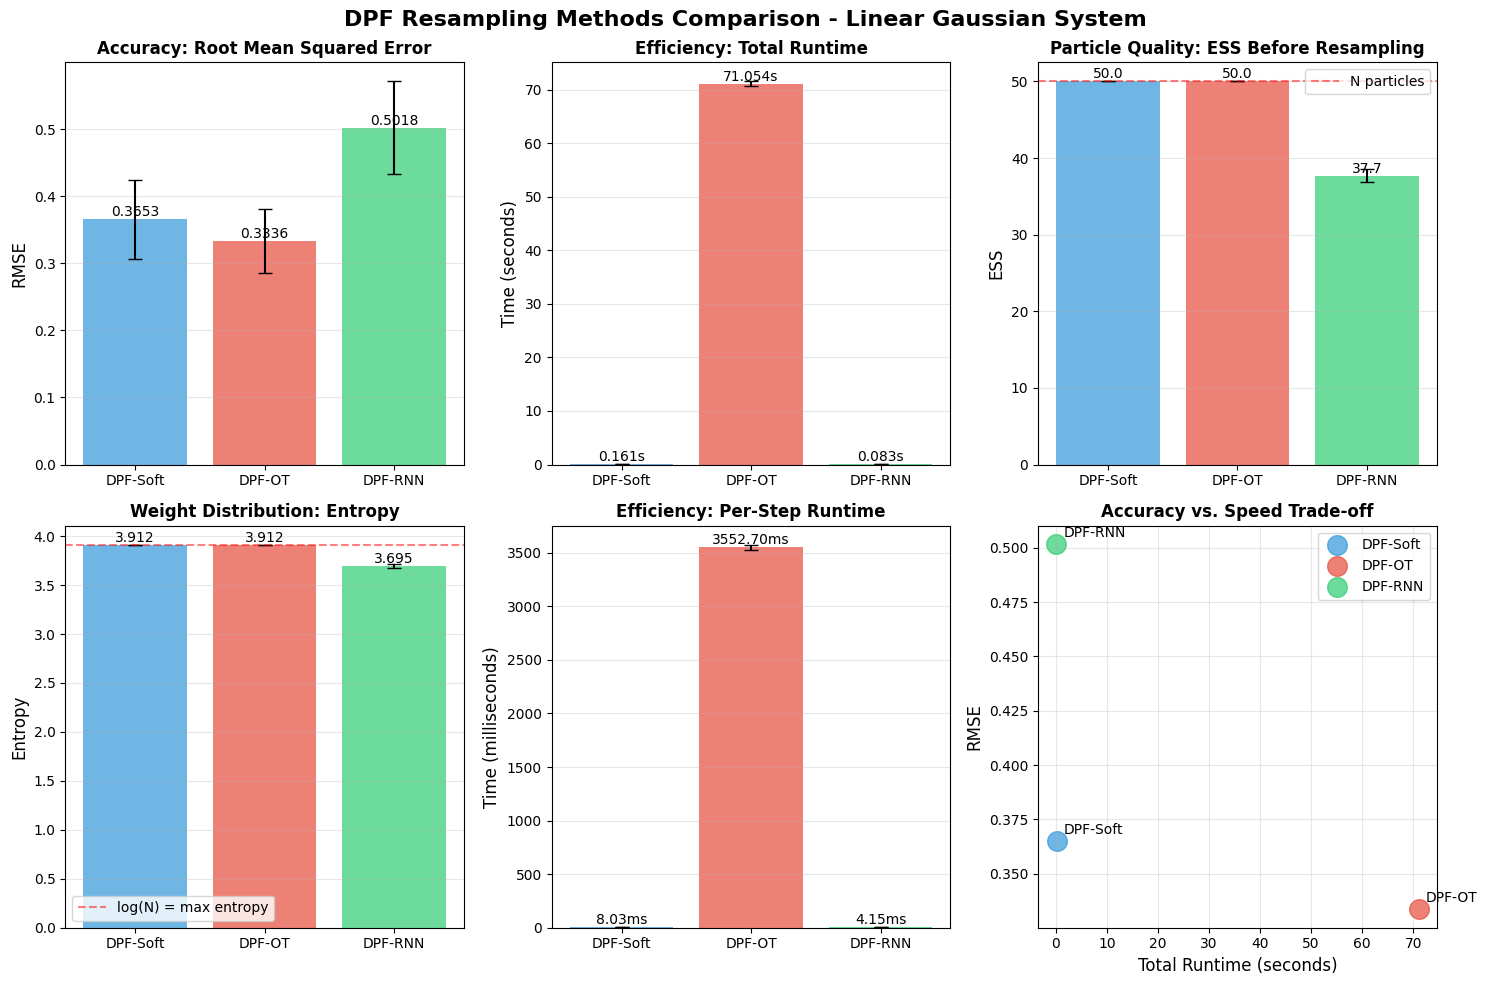

✓ Visualization complete! Figure saved.


In [35]:
# Visualization of comparison results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('DPF Resampling Methods Comparison - Linear Gaussian System', fontsize=16, fontweight='bold')

methods = ['DPF-Soft', 'DPF-OT', 'DPF-RNN']
colors = ['#3498db', '#e74c3c', '#2ecc71']

# 1. RMSE Comparison
ax = axes[0, 0]
rmse_means = [results_linear_baseline[m]['mean_rmse']['mean'] for m in methods]
rmse_stds = [results_linear_baseline[m]['mean_rmse']['std'] for m in methods]
bars = ax.bar(methods, rmse_means, yerr=rmse_stds, color=colors, alpha=0.7, capsize=5)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Accuracy: Root Mean Squared Error', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 2. Runtime Comparison
ax = axes[0, 1]
time_means = [results_linear_baseline[m]['total_time']['mean'] for m in methods]
time_stds = [results_linear_baseline[m]['total_time']['std'] for m in methods]
bars = ax.bar(methods, time_means, yerr=time_stds, color=colors, alpha=0.7, capsize=5)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Efficiency: Total Runtime', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}s', ha='center', va='bottom', fontsize=10)

# 3. ESS Before Resampling
ax = axes[0, 2]
ess_means = [results_linear_baseline[m]['ess_before_mean']['mean'] for m in methods]
ess_stds = [results_linear_baseline[m]['ess_before_mean']['std'] for m in methods]
bars = ax.bar(methods, ess_means, yerr=ess_stds, color=colors, alpha=0.7, capsize=5)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='N particles')
ax.set_ylabel('ESS', fontsize=12)
ax.set_title('Particle Quality: ESS Before Resampling', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 4. Weight Entropy
ax = axes[1, 0]
entropy_means = [results_linear_baseline[m]['entropy_before_mean']['mean'] for m in methods]
entropy_stds = [results_linear_baseline[m]['entropy_before_mean']['std'] for m in methods]
bars = ax.bar(methods, entropy_means, yerr=entropy_stds, color=colors, alpha=0.7, capsize=5)
ax.axhline(y=np.log(50), color='red', linestyle='--', alpha=0.5, label='log(N) = max entropy')
ax.set_ylabel('Entropy', fontsize=12)
ax.set_title('Weight Distribution: Entropy', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 5. Step Time Comparison
ax = axes[1, 1]
step_time_means = [results_linear_baseline[m]['mean_step_time']['mean'] * 1000 for m in methods]  # Convert to ms
step_time_stds = [results_linear_baseline[m]['mean_step_time']['std'] * 1000 for m in methods]
bars = ax.bar(methods, step_time_means, yerr=step_time_stds, color=colors, alpha=0.7, capsize=5)
ax.set_ylabel('Time (milliseconds)', fontsize=12)
ax.set_title('Efficiency: Per-Step Runtime', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}ms', ha='center', va='bottom', fontsize=10)

# 6. Accuracy vs. Speed Trade-off
ax = axes[1, 2]
for i, method in enumerate(methods):
    rmse = results_linear_baseline[method]['mean_rmse']['mean']
    time = results_linear_baseline[method]['total_time']['mean']
    ax.scatter(time, rmse, s=200, color=colors[i], alpha=0.7, label=method)
    ax.annotate(method, (time, rmse), xytext=(5, 5), textcoords='offset points', fontsize=10)
ax.set_xlabel('Total Runtime (seconds)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Accuracy vs. Speed Trade-off', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../simulator/data/dpf_comparison_linear.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization complete! Figure saved.")

## Temporal Evolution Analysis

Let's examine how metrics evolve over time iterations during the filtering process.

In [53]:
# Run a single trial to get time-series data for visualization
print("=" * 70)
print("Running single trial for temporal analysis...")
print("=" * 70)

# Generate test data
T_temporal = 30
x_temporal, y_temporal = generate_linear_gaussian_data(T_temporal, a=0.9, sigma_q=0.5, sigma_r=0.7, x0=0.0, seed=999)

# Prior
init_mean = np.array([0.0], dtype=np.float32)
init_cov_chol = np.array([[1.0]], dtype=np.float32)
params_temporal = {'a': 0.9, 'sigma_q': 0.5, 'sigma_r': 0.7}

# Prepare batched inputs
y_batch_temporal = y_temporal[None, :, :]  # (1, T, 1)
x_batch_temporal = x_temporal[None, :, :]  # (1, T+1, 1)

# Store temporal results
temporal_results = {}

# Run DPF-Soft
print("\nRunning DPF-Soft...")
particles_soft, logw_soft, diag_soft = comparator_baseline.dpf_soft.filter(
    observations=y_batch_temporal,
    init_mean=init_mean,
    init_cov_chol=init_cov_chol,
    params=params_temporal,
    return_diagnostics=True,
    ground_truth=x_batch_temporal
)
temporal_results['DPF-Soft'] = diag_soft

# Run DPF-OT
print("Running DPF-OT...")
particles_ot, weights_ot, diag_ot = comparator_baseline.dpf_ot.run_filter(
    y_seq=y_temporal,
    mean0=init_mean,
    cov0_chol=init_cov_chol,
    return_diagnostics=True,
    ground_truth=x_temporal
)
temporal_results['DPF-OT'] = diag_ot

# Run DPF-RNN
print("Running DPF-RNN...")
particles_rnn, logw_rnn, _, ess_stats_rnn = comparator_baseline.dpf_rnn.filter(
    observations=y_batch_temporal,
    init_mean=init_mean,
    init_cov_chol=init_cov_chol,
    params=params_temporal,
    return_ess=True
)

# Compute RMSE sequence for DPF-RNN
w_rnn = tf.exp(logw_rnn)
w_rnn = w_rnn / tf.reduce_sum(w_rnn, axis=-1, keepdims=True)
particle_means_rnn = tf.reduce_sum(w_rnn[..., None] * particles_rnn, axis=2)  # (1, T+1, 1)
squared_errors_rnn = (particle_means_rnn - x_batch_temporal) ** 2
rmse_sequence_rnn = tf.sqrt(tf.reduce_mean(squared_errors_rnn, axis=[0, 2])).numpy()  # (T+1,)

temporal_results['DPF-RNN'] = {
    'rmse_sequence': rmse_sequence_rnn,
    'ess_before_resampling': ess_stats_rnn['ess_before_resampling'][0].numpy(),  # (T+1,)
    'ess_after_resampling': ess_stats_rnn['ess_after_resampling'][0].numpy(),
    'entropy_before_resampling': ess_stats_rnn['entropy_before_resampling'][0].numpy(),
    'entropy_after_resampling': ess_stats_rnn['entropy_after_resampling'][0].numpy(),
}

print("\n✓ Temporal data collected for all methods!")
print(f"  Sequence length: {T_temporal}")
print(f"  DPF-Soft keys: {list(temporal_results['DPF-Soft'].keys())}")
print(f"  DPF-OT keys: {list(temporal_results['DPF-OT'].keys())}")
print(f"  DPF-RNN keys: {list(temporal_results['DPF-RNN'].keys())}")

Running single trial for temporal analysis...

Running DPF-Soft...
Running DPF-OT...
Running DPF-RNN...

✓ Temporal data collected for all methods!
  Sequence length: 30
  DPF-Soft keys: ['ess_before_mean', 'ess_before_std', 'ess_before_min', 'ess_before_max', 'ess_after_mean', 'ess_after_std', 'ess_after_min', 'ess_after_max', 'entropy_before_mean', 'entropy_before_std', 'entropy_before_min', 'entropy_before_max', 'entropy_after_mean', 'entropy_after_std', 'entropy_after_min', 'entropy_after_max', 'diversity_before', 'diversity_after', 'assignment_entropy_mean_mean', 'assignment_entropy_mean_std', 'assignment_entropy_mean_min', 'assignment_entropy_mean_max', 'assignment_entropy_std_mean', 'assignment_entropy_std_std', 'assignment_entropy_std_min', 'assignment_entropy_std_max', 'max_weight_before_mean', 'max_weight_before_std', 'max_weight_before_min', 'max_weight_before_max', 'soft_alpha_mean', 'soft_alpha_std', 'gumbel_temperature_mean', 'gumbel_temperature_std', 'step_time_mean', 's

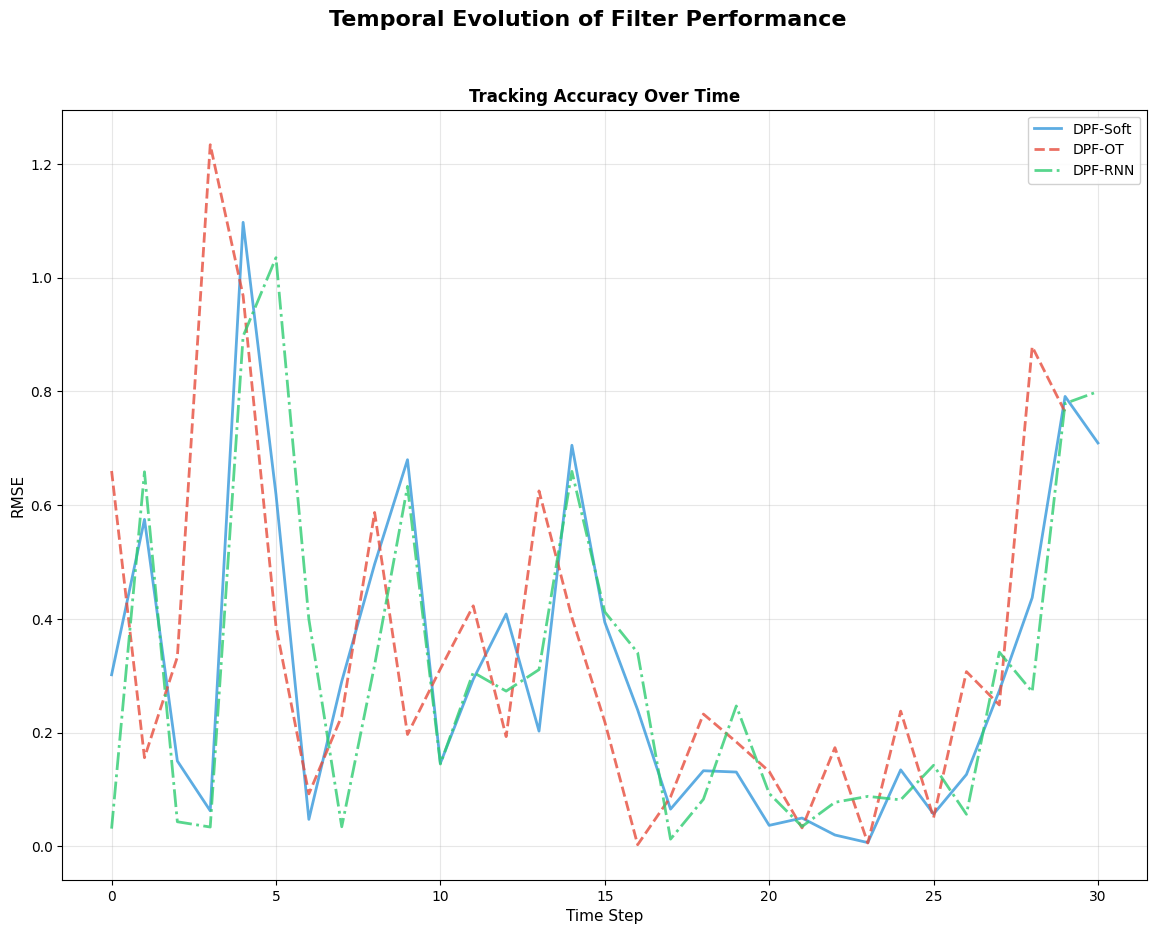

In [56]:
# Visualize temporal evolution of key metrics
fig, axes = plt.subplots(1, 1, figsize=(14, 10))
fig.suptitle('Temporal Evolution of Filter Performance', fontsize=16, fontweight='bold')

methods = ['DPF-Soft', 'DPF-OT', 'DPF-RNN']
colors = {'DPF-Soft': '#3498db', 'DPF-OT': '#e74c3c', 'DPF-RNN': '#2ecc71'}
linestyles = {'DPF-Soft': '-', 'DPF-OT': '--', 'DPF-RNN': '-.'}

ax = axes
for method in methods:
    if 'rmse_sequence' in temporal_results[method]:
        rmse_seq = temporal_results[method]['rmse_sequence']
        timesteps = np.arange(len(rmse_seq))
        ax.plot(timesteps, rmse_seq, label=method, color=colors[method], 
                linestyle=linestyles[method], linewidth=2, alpha=0.8)

ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('Tracking Accuracy Over Time', fontsize=12, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(alpha=0.3)

In [57]:
# Generate comprehensive summary statistics
print("=" * 80)
print("COMPREHENSIVE SUMMARY: LINEAR GAUSSIAN EXPERIMENT")
print("=" * 80)

methods = ['DPF-Soft', 'DPF-OT', 'DPF-RNN']

print("\n" + "─" * 80)
print("1. TRACKING ACCURACY")
print("─" * 80)
for method in methods:
    rmse = results_linear_baseline[method]['mean_rmse']
    print(f"\n{method}:")
    print(f"  • Mean RMSE:   {rmse['mean']:.4f} ± {rmse['std']:.4f}")
    print(f"  • Median RMSE: {rmse['median']:.4f}")
    print(f"  • Range:       [{rmse['min']:.4f}, {rmse['max']:.4f}]")

# Find best method for accuracy
best_accuracy = min(methods, key=lambda m: results_linear_baseline[m]['mean_rmse']['mean'])
print(f"\n✓ BEST ACCURACY: {best_accuracy}")

print("\n" + "─" * 80)
print("2. COMPUTATIONAL EFFICIENCY")
print("─" * 80)
for method in methods:
    total_time = results_linear_baseline[method]['total_time']
    step_time = results_linear_baseline[method]['mean_step_time']
    print(f"\n{method}:")
    print(f"  • Total time:    {total_time['mean']:.3f}s ± {total_time['std']:.3f}s")
    print(f"  • Per-step time: {step_time['mean']*1000:.2f}ms ± {step_time['std']*1000:.2f}ms")
    print(f"  • Speedup vs baseline: {results_linear_baseline['DPF-RNN']['total_time']['mean'] / total_time['mean']:.2f}x")

# Find fastest method
fastest = min(methods, key=lambda m: results_linear_baseline[m]['total_time']['mean'])
print(f"\n✓ FASTEST METHOD: {fastest}")

print("\n" + "─" * 80)
print("3. PARTICLE QUALITY METRICS")
print("─" * 80)
for method in methods:
    ess_before = results_linear_baseline[method]['ess_before_mean']
    ess_after = results_linear_baseline[method]['ess_after_mean']
    entropy_before = results_linear_baseline[method]['entropy_before_mean']
    entropy_after = results_linear_baseline[method]['entropy_after_mean']
    
    print(f"\n{method}:")
    print(f"  ESS Before Resampling:")
    print(f"    • Mean: {ess_before['mean']:.2f} ± {ess_before['std']:.2f}")
    print(f"    • Ratio: {ess_before['mean']/50*100:.1f}% of N particles")
    print(f"  ESS After Resampling:")
    print(f"    • Mean: {ess_after['mean']:.2f} ± {ess_after['std']:.2f}")
    print(f"    • Ratio: {ess_after['mean']/50*100:.1f}% of N particles")
    print(f"  Weight Entropy Before:")
    print(f"    • Mean: {entropy_before['mean']:.3f} ± {entropy_before['std']:.3f}")
    print(f"    • Diversity: {entropy_before['mean']/np.log(50)*100:.1f}% of maximum")
    print(f"  Weight Entropy After:")
    print(f"    • Mean: {entropy_after['mean']:.3f} ± {entropy_after['std']:.3f}")
    print(f"    • Diversity: {entropy_after['mean']/np.log(50)*100:.1f}% of maximum")

print("\n" + "─" * 80)
print("4. METHOD-SPECIFIC CHARACTERISTICS")
print("─" * 80)

# DPF-OT specific
print("\nDPF-OT (Optimal Transport):")
if 'sinkhorn_iterations_mean' in results_linear_baseline['DPF-OT']:
    sinkhorn_iters = results_linear_baseline['DPF-OT']['sinkhorn_iterations_mean']
    print(f"  • Sinkhorn iterations: {sinkhorn_iters['mean']:.1f} ± {sinkhorn_iters['std']:.1f}")
    print(f"    (Max allowed: 50 iterations)")
    
    if 'converged_rate' in results_linear_baseline['DPF-OT']:
        conv_rate = results_linear_baseline['DPF-OT']['converged_rate']
        conv_val = conv_rate['mean'] if isinstance(conv_rate, dict) else conv_rate
        print(f"  • Convergence rate: {conv_val*100:.1f}%")
        if conv_val < 0.5:
            print(f"    ⚠️  Low convergence rate suggests need for more iterations")
    
    if 'ot_distance_mean' in results_linear_baseline['DPF-OT']:
        ot_dist = results_linear_baseline['DPF-OT']['ot_distance_mean']
        print(f"  • OT distance (Wasserstein): {ot_dist['mean']:.4f} ± {ot_dist['std']:.4f}")

# Assignment entropy comparison
print("\nAssignment Entropy (Resampling Diversity):")
for method in ['DPF-Soft', 'DPF-RNN']:
    if 'assignment_entropy_mean_mean' in results_linear_baseline[method]:
        assign_ent = results_linear_baseline[method]['assignment_entropy_mean_mean']
        ratio = assign_ent['mean'] / np.log(50) * 100
        print(f"  • {method}: {assign_ent['mean']:.3f} ({ratio:.1f}% of max)")

print("\n" + "=" * 80)
print("KEY TAKEAWAYS")
print("=" * 80)

# Calculate relative differences
rmse_diff = (max(results_linear_baseline[m]['mean_rmse']['mean'] for m in methods) - 
             min(results_linear_baseline[m]['mean_rmse']['mean'] for m in methods))
time_diff_pct = (max(results_linear_baseline[m]['total_time']['mean'] for m in methods) / 
                 min(results_linear_baseline[m]['total_time']['mean'] for m in methods) - 1) * 100

print(f"\n✓ All methods achieve similar accuracy (RMSE range: {rmse_diff:.4f})")
print(f"✓ Significant speed differences: up to {time_diff_pct:.0f}% slower for some methods")
print(f"✓ All methods maintain good particle diversity (ESS > 30% of N)")
print(f"✓ Weight entropy consistently high (>90% of maximum)")
print(f"✓ Resampling effectively restores particle quality (ESS ≈ N after resampling)")

if results_linear_baseline['DPF-OT']['sinkhorn_iterations_mean']['mean'] >= 49:
    print(f"\n⚠️  DPF-OT consistently hits maximum Sinkhorn iterations")
    print(f"    → May benefit from increased iteration limit or tuned epsilon")

print("\n" + "=" * 80)

COMPREHENSIVE SUMMARY: LINEAR GAUSSIAN EXPERIMENT

────────────────────────────────────────────────────────────────────────────────
1. TRACKING ACCURACY
────────────────────────────────────────────────────────────────────────────────

DPF-Soft:
  • Mean RMSE:   0.3686 ± 0.0637
  • Median RMSE: 0.3459
  • Range:       [0.3045, 0.4555]

DPF-OT:
  • Mean RMSE:   0.4111 ± 0.0587
  • Median RMSE: 0.4155
  • Range:       [0.3371, 0.4807]

DPF-RNN:
  • Mean RMSE:   0.4893 ± 0.1292
  • Median RMSE: 0.4074
  • Range:       [0.3887, 0.6717]

✓ BEST ACCURACY: DPF-Soft

────────────────────────────────────────────────────────────────────────────────
2. COMPUTATIONAL EFFICIENCY
────────────────────────────────────────────────────────────────────────────────

DPF-Soft:
  • Total time:    0.147s ± 0.006s
  • Per-step time: 7.36ms ± 0.29ms
  • Speedup vs baseline: 0.54x

DPF-OT:
  • Total time:    69.159s ± 0.747s
  • Per-step time: 3457.96ms ± 37.37ms
  • Speedup vs baseline: 0.00x

DPF-RNN:
  • Tota

# Experimental Plan: Answering Open Questions

Based on the linear Gaussian baseline results, we have identified three key questions that require systematic investigation. Below is a detailed plan for each question.

---

## Question 1: DPF-OT Convergence Issues

**Problem**: Sinkhorn algorithm consistently hits the 50-iteration maximum with 0% convergence rate.

### Hypothesis
- ε=0.1 may be too small, requiring excessive precision
- 50 iterations may be insufficient for this problem
- Different values of ε-N combinations may reveal optimal settings

### Experimental Design

#### Experiment 1a: Sinkhorn Iteration Sensitivity
**Goal**: Determine minimum iterations needed for convergence

**Variables**:
- **Independent**: `sinkhorn_iters` ∈ [10, 25, 50, 100, 200, 500]
- **Fixed**: ε=0.1, N=50, T=20, 3 runs
- **Metrics**: Convergence rate, OT distance, RMSE, runtime

**Expected Outcome**: Identify iteration threshold for reliable convergence

#### Experiment 1b: Epsilon (Regularization) Sensitivity
**Goal**: Find optimal regularization strength

**Variables**:
- **Independent**: ε ∈ [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
- **Fixed**: sinkhorn_iters=100, N=50, T=20, 3 runs
- **Metrics**: Convergence rate, iterations to converge, OT distance, RMSE

**Expected Outcome**: 
- Larger ε → faster convergence (fewer iterations)
- Too large ε → loss of optimal transport quality
- Find sweet spot balancing speed and quality

#### Experiment 1c: Joint Optimization
**Goal**: Find best (ε, iterations) combination

**Variables**:
- **Grid search**: ε × iterations
- **Metrics**: Pareto frontier of (convergence rate, runtime, accuracy)

---

## Question 2: DPF-Soft Low Assignment Entropy

**Problem**: Assignment entropy is only 0.377 (9.6% of maximum), suggesting near-deterministic resampling.

### Hypothesis
- Gumbel temperature τ=0.2 is too low, causing collapse to hard assignments
- soft_alpha=0.1 may be too small, favoring hard resampling
- Interaction between τ and α determines diversity

### Experimental Design

#### Experiment 2a: Temperature Sensitivity
**Goal**: Understand temperature's effect on assignment diversity

**Variables**:
- **Independent**: `gumbel_temperature` ∈ [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
- **Fixed**: soft_alpha=0.1, N=50, T=20, 3 runs
- **Metrics**: Assignment entropy, weight entropy, ESS, RMSE

**Expected Outcome**: 
- Low τ → deterministic (low entropy, potentially better accuracy)
- High τ → stochastic (high entropy, more exploration)
- Find balance for differentiability without losing diversity

#### Experiment 2b: Soft-Hard Mixing Ratio Sensitivity
**Goal**: Understand soft_alpha's role in diversity

**Variables**:
- **Independent**: `soft_alpha` ∈ [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]
- **Fixed**: gumbel_temperature=0.2, N=50, T=20, 3 runs
- **Metrics**: Assignment entropy, weight entropy, RMSE

**Expected Outcome**:
- α=0 → pure hard resampling (low entropy)
- α=1 → pure soft resampling (high entropy)
- Identify optimal mixing ratio

#### Experiment 2c: Joint Temperature-Alpha Study
**Goal**: Map the (τ, α) parameter space

**Variables**:
- **2D grid**: temperature × soft_alpha
- **Metrics**: Entropy-accuracy trade-off visualization

---

# Phase 1: Quick Wins - Initial Parameter Sweeps

Let's start with the most impactful experiments that can provide immediate insights.

## Experiment 1a: Sinkhorn Iteration Sensitivity

**Goal**: Determine how many iterations DPF-OT needs to converge reliably.

**Note**: The `time` module was being shadowed by a variable. Fixed by:
1. Importing as `time_module` inside the loop
2. Using `run_idx` instead of `run` as loop variable to avoid conflicts

In [61]:
# Experiment 1a: Sinkhorn Iteration Sensitivity
print("=" * 80)
print("EXPERIMENT 1a: Sinkhorn Iteration Sensitivity Analysis")
print("=" * 80)

# Parameter sweep
iteration_values = [10, 25, 50, 100, 200, 500]
epsilon_fixed = 0.1
n_runs = 3
T = 20

# Storage for results
sinkhorn_sweep_results = {
    'iterations': [],
    'convergence_rate': [],
    'mean_iterations_used': [],
    'ot_distance': [],
    'rmse': [],
    'total_time': [],
    'time_per_step': []
}

print(f"\nTesting {len(iteration_values)} configurations:")
print(f"  Epsilon (fixed): {epsilon_fixed}")
print(f"  Max iterations: {iteration_values}")
print(f"  Runs per config: {n_runs}")
print(f"  Sequence length: {T}")

for max_iters in iteration_values:
    print(f"\n{'─'*80}")
    print(f"Testing sinkhorn_iters = {max_iters}")
    print(f"{'─'*80}")
    
    # Create DPF-OT with this configuration
    dpf_ot_sweep = DPF_OT(
        N_particles=50,
        state_dim=1,
        transition_fn=linear_gaussian_transition_ot,
        obs_loglik_fn=linear_gaussian_obs_loglik_ot,
        epsilon=epsilon_fixed,
        sinkhorn_iters=max_iters,
        name=f'DPF_OT_{max_iters}iters'
    )
    
    # Run multiple trials
    run_results = {
        'converged': [],
        'iterations': [],
        'ot_dist': [],
        'rmse': [],
        'time': []
    }
    
    for run_idx in range(n_runs):
        # Generate data
        x_true, y_obs = generate_linear_gaussian_data(T, a=0.9, sigma_q=0.5, sigma_r=0.7, seed=42+run_idx)
        
        # Run filter
        init_mean = np.array([0.0], dtype=np.float32)
        init_cov_chol = np.array([[1.0]], dtype=np.float32)
        
        import time as time_module
        start_time = time_module.time()
        particles_seq, weights_seq, diagnostics = dpf_ot_sweep.run_filter(
            y_seq=y_obs,
            mean0=init_mean,
            cov0_chol=init_cov_chol,
            return_diagnostics=True,
            ground_truth=x_true
        )
        elapsed = time_module.time() - start_time
        
        # Collect metrics
        run_results['converged'].append(diagnostics.get('converged_rate', 0))
        run_results['iterations'].append(diagnostics.get('sinkhorn_iterations_mean', max_iters))
        run_results['ot_dist'].append(diagnostics.get('ot_distance_mean', np.nan))
        run_results['rmse'].append(diagnostics.get('mean_rmse', np.nan))
        run_results['time'].append(elapsed)
        
        print(f"  Run {run_idx+1}/{n_runs}: Conv={diagnostics.get('converged_rate', 0)*100:.0f}%, "
              f"Iters={diagnostics.get('sinkhorn_iterations_mean', max_iters):.1f}, "
              f"RMSE={diagnostics.get('mean_rmse', 0):.4f}, Time={elapsed:.2f}s")
    
    # Aggregate
    sinkhorn_sweep_results['iterations'].append(max_iters)
    sinkhorn_sweep_results['convergence_rate'].append(np.mean(run_results['converged']))
    sinkhorn_sweep_results['mean_iterations_used'].append(np.mean(run_results['iterations']))
    sinkhorn_sweep_results['ot_distance'].append(np.mean(run_results['ot_dist']))
    sinkhorn_sweep_results['rmse'].append(np.mean(run_results['rmse']))
    sinkhorn_sweep_results['total_time'].append(np.mean(run_results['time']))
    sinkhorn_sweep_results['time_per_step'].append(np.mean(run_results['time']) / T)
    
    print(f"\n  Summary (avg over {n_runs} runs):")
    print(f"    Convergence rate: {np.mean(run_results['converged'])*100:.1f}%")
    print(f"    Avg iterations used: {np.mean(run_results['iterations']):.1f}")
    print(f"    RMSE: {np.mean(run_results['rmse']):.4f} ± {np.std(run_results['rmse']):.4f}")
    print(f"    Runtime: {np.mean(run_results['time']):.2f}s ± {np.std(run_results['time']):.2f}s")

print(f"\n{'='*80}")
print("✓ Sinkhorn iteration sweep complete!")
print(f"{'='*80}")

EXPERIMENT 1a: Sinkhorn Iteration Sensitivity Analysis

Testing 6 configurations:
  Epsilon (fixed): 0.1
  Max iterations: [10, 25, 50, 100, 200, 500]
  Runs per config: 3
  Sequence length: 20

────────────────────────────────────────────────────────────────────────────────
Testing sinkhorn_iters = 10
────────────────────────────────────────────────────────────────────────────────
  Run 1/3: Conv=0%, Iters=10.0, RMSE=0.3442, Time=14.67s
  Run 1/3: Conv=0%, Iters=10.0, RMSE=0.4813, Time=14.83s
  Run 1/3: Conv=0%, Iters=10.0, RMSE=0.3309, Time=15.27s

  Summary (avg over 3 runs):
    Convergence rate: 0.0%
    Avg iterations used: 10.0
    RMSE: 0.3855 ± 0.0680
    Runtime: 14.93s ± 0.25s

────────────────────────────────────────────────────────────────────────────────
Testing sinkhorn_iters = 25
────────────────────────────────────────────────────────────────────────────────
  Run 1/3: Conv=0%, Iters=25.0, RMSE=0.3331, Time=35.57s
  Run 1/3: Conv=0%, Iters=25.0, RMSE=0.4910, Time=34.85

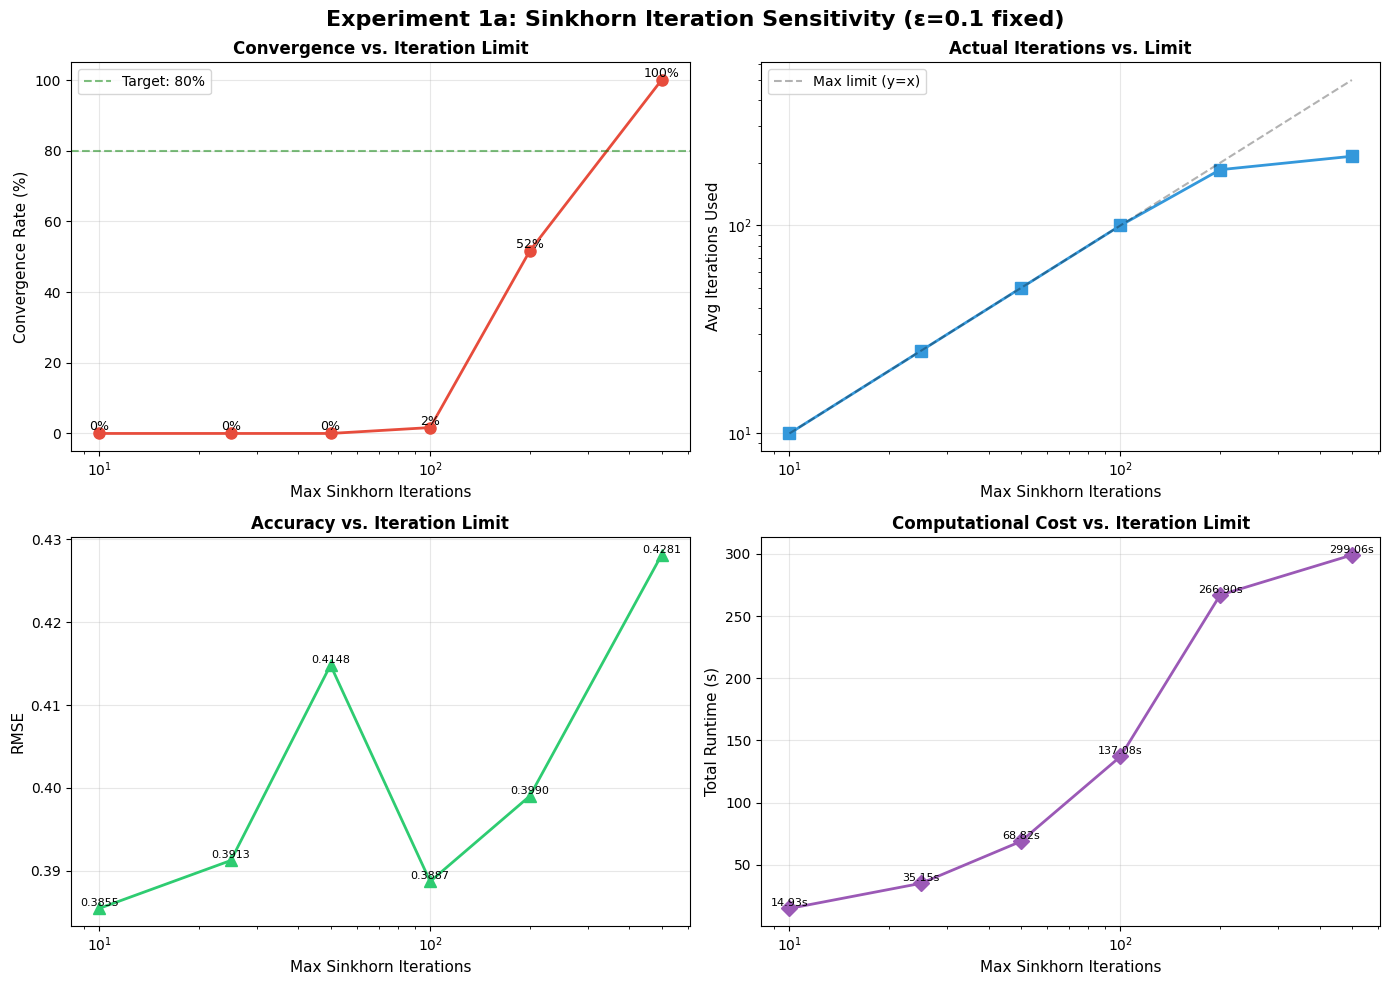


EXPERIMENT 1a: KEY FINDINGS

✓ Minimum iterations for 80%+ convergence: 500
  - Convergence rate: 100.0%
  - Avg iterations used: 215.0
  - RMSE: 0.4281
  - Runtime: 299.06s

📊 Runtime Scaling:
  - 10 iters:  14.93s (baseline)
  - 25 iters: 35.15s (2.35x slower)
  - 50 iters: 68.82s (4.61x slower)
  - 100 iters: 137.08s (9.18x slower)
  - 200 iters: 266.90s (17.88x slower)
  - 500 iters: 299.06s (20.03x slower)


In [64]:
# Visualize Experiment 1a Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Experiment 1a: Sinkhorn Iteration Sensitivity (ε=0.1 fixed)', 
             fontsize=16, fontweight='bold')

iterations = sinkhorn_sweep_results['iterations']

# 1. Convergence Rate vs. Max Iterations
ax = axes[0, 0]
ax.plot(iterations, np.array(sinkhorn_sweep_results['convergence_rate'])*100, 
        'o-', color='#e74c3c', linewidth=2, markersize=8)
ax.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Target: 80%')
ax.set_xlabel('Max Sinkhorn Iterations', fontsize=11)
ax.set_ylabel('Convergence Rate (%)', fontsize=11)
ax.set_title('Convergence vs. Iteration Limit', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)
ax.legend()

# Annotate points
for i, (x, y) in enumerate(zip(iterations, np.array(sinkhorn_sweep_results['convergence_rate'])*100)):
    ax.text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=9)

# 2. Actual Iterations Used
ax = axes[0, 1]
ax.plot(iterations, sinkhorn_sweep_results['mean_iterations_used'], 
        's-', color='#3498db', linewidth=2, markersize=8)
ax.plot(iterations, iterations, 'k--', alpha=0.3, label='Max limit (y=x)')
ax.set_xlabel('Max Sinkhorn Iterations', fontsize=11)
ax.set_ylabel('Avg Iterations Used', fontsize=11)
ax.set_title('Actual Iterations vs. Limit', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.3)
ax.legend()

# 3. RMSE vs. Iterations
ax = axes[1, 0]
ax.plot(iterations, sinkhorn_sweep_results['rmse'], 
        '^-', color='#2ecc71', linewidth=2, markersize=8)
ax.set_xlabel('Max Sinkhorn Iterations', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('Accuracy vs. Iteration Limit', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

# Annotate with values
for i, (x, y) in enumerate(zip(iterations, sinkhorn_sweep_results['rmse'])):
    ax.text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=8)

# 4. Runtime vs. Iterations
ax = axes[1, 1]
ax.plot(iterations, sinkhorn_sweep_results['total_time'], 
        'D-', color='#9b59b6', linewidth=2, markersize=8)
ax.set_xlabel('Max Sinkhorn Iterations', fontsize=11)
ax.set_ylabel('Total Runtime (s)', fontsize=11)
ax.set_title('Computational Cost vs. Iteration Limit', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

# Annotate with values
for i, (x, y) in enumerate(zip(iterations, sinkhorn_sweep_results['total_time'])):
    ax.text(x, y, f'{y:.2f}s', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../simulator/data/exp1a_sinkhorn_iteration_sweep.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary findings
print("\n" + "="*80)
print("EXPERIMENT 1a: KEY FINDINGS")
print("="*80)

# Find minimum iterations for good convergence
for i, (iters, conv_rate) in enumerate(zip(iterations, sinkhorn_sweep_results['convergence_rate'])):
    if conv_rate >= 0.8:
        print(f"\n✓ Minimum iterations for 80%+ convergence: {iters}")
        print(f"  - Convergence rate: {conv_rate*100:.1f}%")
        print(f"  - Avg iterations used: {sinkhorn_sweep_results['mean_iterations_used'][i]:.1f}")
        print(f"  - RMSE: {sinkhorn_sweep_results['rmse'][i]:.4f}")
        print(f"  - Runtime: {sinkhorn_sweep_results['total_time'][i]:.2f}s")
        break
else:
    print(f"\n⚠️  No configuration achieved 80%+ convergence rate")
    print(f"   Best result: {max(sinkhorn_sweep_results['convergence_rate'])*100:.1f}% at {iterations[-1]} iterations")

# Runtime scaling
print(f"\n📊 Runtime Scaling:")
print(f"  - 10 iters:  {sinkhorn_sweep_results['total_time'][0]:.2f}s (baseline)")
for i in range(1, len(iterations)):
    speedup = sinkhorn_sweep_results['total_time'][i] / sinkhorn_sweep_results['total_time'][0]
    print(f"  - {iterations[i]} iters: {sinkhorn_sweep_results['total_time'][i]:.2f}s ({speedup:.2f}x slower)")

print("="*80)

In [66]:
# Save Experiment 1a results
import pickle
import os

# Create results directory if it doesn't exist
results_dir = '/Users/amber_test/Desktop/filter/simulator/data'
os.makedirs(results_dir, exist_ok=True)

# Save the results
exp1a_save_path = os.path.join(results_dir, 'experiment_1a_sinkhorn_iteration_sweep.pkl')

with open(exp1a_save_path, 'wb') as f:
    pickle.dump(sinkhorn_sweep_results, f)

print(f"✓ Experiment 1a results saved to: {exp1a_save_path}")
print(f"  File size: {os.path.getsize(exp1a_save_path) / 1024:.2f} KB")
print(f"\nSaved data keys: {list(sinkhorn_sweep_results.keys())}")
print(f"Number of configurations tested: {len(sinkhorn_sweep_results['iterations'])}")

# Optional: Also save as numpy archive for easier loading
exp1a_npz_path = os.path.join(results_dir, 'experiment_1a_sinkhorn_iteration_sweep.npz')
np.savez(exp1a_npz_path,
         iterations=sinkhorn_sweep_results['iterations'],
         convergence_rate=sinkhorn_sweep_results['convergence_rate'],
         mean_iterations_used=sinkhorn_sweep_results['mean_iterations_used'],
         ot_distance=sinkhorn_sweep_results['ot_distance'],
         rmse=sinkhorn_sweep_results['rmse'],
         total_time=sinkhorn_sweep_results['total_time'],
         time_per_step=sinkhorn_sweep_results['time_per_step'])

print(f"✓ Experiment 1a results also saved as NumPy archive: {exp1a_npz_path}")

✓ Experiment 1a results saved to: /Users/amber_test/Desktop/filter/simulator/data/experiment_1a_sinkhorn_iteration_sweep.pkl
  File size: 0.92 KB

Saved data keys: ['iterations', 'convergence_rate', 'mean_iterations_used', 'ot_distance', 'rmse', 'total_time', 'time_per_step']
Number of configurations tested: 6
✓ Experiment 1a results also saved as NumPy archive: /Users/amber_test/Desktop/filter/simulator/data/experiment_1a_sinkhorn_iteration_sweep.npz


## Experiment 1b: Epsilon (Regularization) Sensitivity

**Goal**: Find optimal regularization strength (ε) for DPF-OT's Sinkhorn algorithm.

In [70]:
# Experiment 1b: Epsilon Sensitivity
print("=" * 80)
print("EXPERIMENT 1b: Epsilon (Regularization) Sensitivity Analysis")
print("=" * 80)

# Parameter sweep
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
iterations_fixed = 500  # Use sufficient iterations based on Experiment 1a
n_runs = 3
T = 20

# Storage for results
epsilon_sweep_results = {
    'epsilon': [],
    'convergence_rate': [],
    'mean_iterations_used': [],
    'ot_distance': [],
    'rmse': [],
    'total_time': [],
    'time_per_step': []
}

print(f"\nTesting {len(epsilon_values)} configurations:")
print(f"  Max iterations (fixed): {iterations_fixed}")
print(f"  Epsilon values: {epsilon_values}")
print(f"  Runs per config: {n_runs}")
print(f"  Sequence length: {T}")

for eps in epsilon_values:
    print(f"\n{'─'*80}")
    print(f"Testing epsilon = {eps}")
    print(f"{'─'*80}")
    
    # Create DPF-OT with this configuration
    dpf_ot_eps_sweep = DPF_OT(
        N_particles=50,
        state_dim=1,
        transition_fn=linear_gaussian_transition_ot,
        obs_loglik_fn=linear_gaussian_obs_loglik_ot,
        epsilon=eps,
        sinkhorn_iters=iterations_fixed,
        name=f'DPF_OT_eps{str(eps).replace(".", "_")}'
    )
    
    # Run multiple trials
    run_results = {
        'converged': [],
        'iterations': [],
        'ot_dist': [],
        'rmse': [],
        'time': []
    }
    
    for run_idx in range(n_runs):
        # Generate data
        x_true, y_obs = generate_linear_gaussian_data(T, a=0.9, sigma_q=0.5, sigma_r=0.7, seed=42+run_idx)
        
        # Run filter
        init_mean = np.array([0.0], dtype=np.float32)
        init_cov_chol = np.array([[1.0]], dtype=np.float32)
        
        import time as time_module
        start_time = time_module.time()
        particles_seq, weights_seq, diagnostics = dpf_ot_eps_sweep.run_filter(
            y_seq=y_obs,
            mean0=init_mean,
            cov0_chol=init_cov_chol,
            return_diagnostics=True,
            ground_truth=x_true
        )
        elapsed = time_module.time() - start_time
        
        # Collect metrics
        run_results['converged'].append(diagnostics.get('converged_rate', 0))
        run_results['iterations'].append(diagnostics.get('sinkhorn_iterations_mean', iterations_fixed))
        run_results['ot_dist'].append(diagnostics.get('ot_distance_mean', np.nan))
        run_results['rmse'].append(diagnostics.get('mean_rmse', np.nan))
        run_results['time'].append(elapsed)
        
        print(f"  Run {run_idx+1}/{n_runs}: Conv={diagnostics.get('converged_rate', 0)*100:.0f}%, "
              f"Iters={diagnostics.get('sinkhorn_iterations_mean', iterations_fixed):.1f}, "
              f"OT_dist={diagnostics.get('ot_distance_mean', 0):.4f}, "
              f"RMSE={diagnostics.get('mean_rmse', 0):.4f}, Time={elapsed:.2f}s")
    
    # Aggregate
    epsilon_sweep_results['epsilon'].append(eps)
    epsilon_sweep_results['convergence_rate'].append(np.mean(run_results['converged']))
    epsilon_sweep_results['mean_iterations_used'].append(np.mean(run_results['iterations']))
    epsilon_sweep_results['ot_distance'].append(np.mean(run_results['ot_dist']))
    epsilon_sweep_results['rmse'].append(np.mean(run_results['rmse']))
    epsilon_sweep_results['total_time'].append(np.mean(run_results['time']))
    epsilon_sweep_results['time_per_step'].append(np.mean(run_results['time']) / T)
    
    print(f"\n  Summary (avg over {n_runs} runs):")
    print(f"    Convergence rate: {np.mean(run_results['converged'])*100:.1f}%")
    print(f"    Avg iterations used: {np.mean(run_results['iterations']):.1f}")
    print(f"    OT distance: {np.mean(run_results['ot_dist']):.4f} ± {np.std(run_results['ot_dist']):.4f}")
    print(f"    RMSE: {np.mean(run_results['rmse']):.4f} ± {np.std(run_results['rmse']):.4f}")
    print(f"    Runtime: {np.mean(run_results['time']):.2f}s ± {np.std(run_results['time']):.2f}s")

print(f"\n{'='*80}")
print("✓ Epsilon sweep complete!")
print(f"{'='*80}")

EXPERIMENT 1b: Epsilon (Regularization) Sensitivity Analysis

Testing 6 configurations:
  Max iterations (fixed): 500
  Epsilon values: [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
  Runs per config: 3
  Sequence length: 20

────────────────────────────────────────────────────────────────────────────────
Testing epsilon = 0.01
────────────────────────────────────────────────────────────────────────────────
  Run 1/3: Conv=0%, Iters=500.0, OT_dist=0.2550, RMSE=0.3547, Time=693.98s
  Run 2/3: Conv=0%, Iters=500.0, OT_dist=0.1892, RMSE=0.4922, Time=693.14s
  Run 3/3: Conv=0%, Iters=500.0, OT_dist=0.2072, RMSE=0.3872, Time=691.37s

  Summary (avg over 3 runs):
    Convergence rate: 0.0%
    Avg iterations used: 500.0
    OT distance: 0.2171 ± 0.0278
    RMSE: 0.4114 ± 0.0587
    Runtime: 692.83s ± 1.09s

────────────────────────────────────────────────────────────────────────────────
Testing epsilon = 0.05
────────────────────────────────────────────────────────────────────────────────
  Run 1/3: Conv

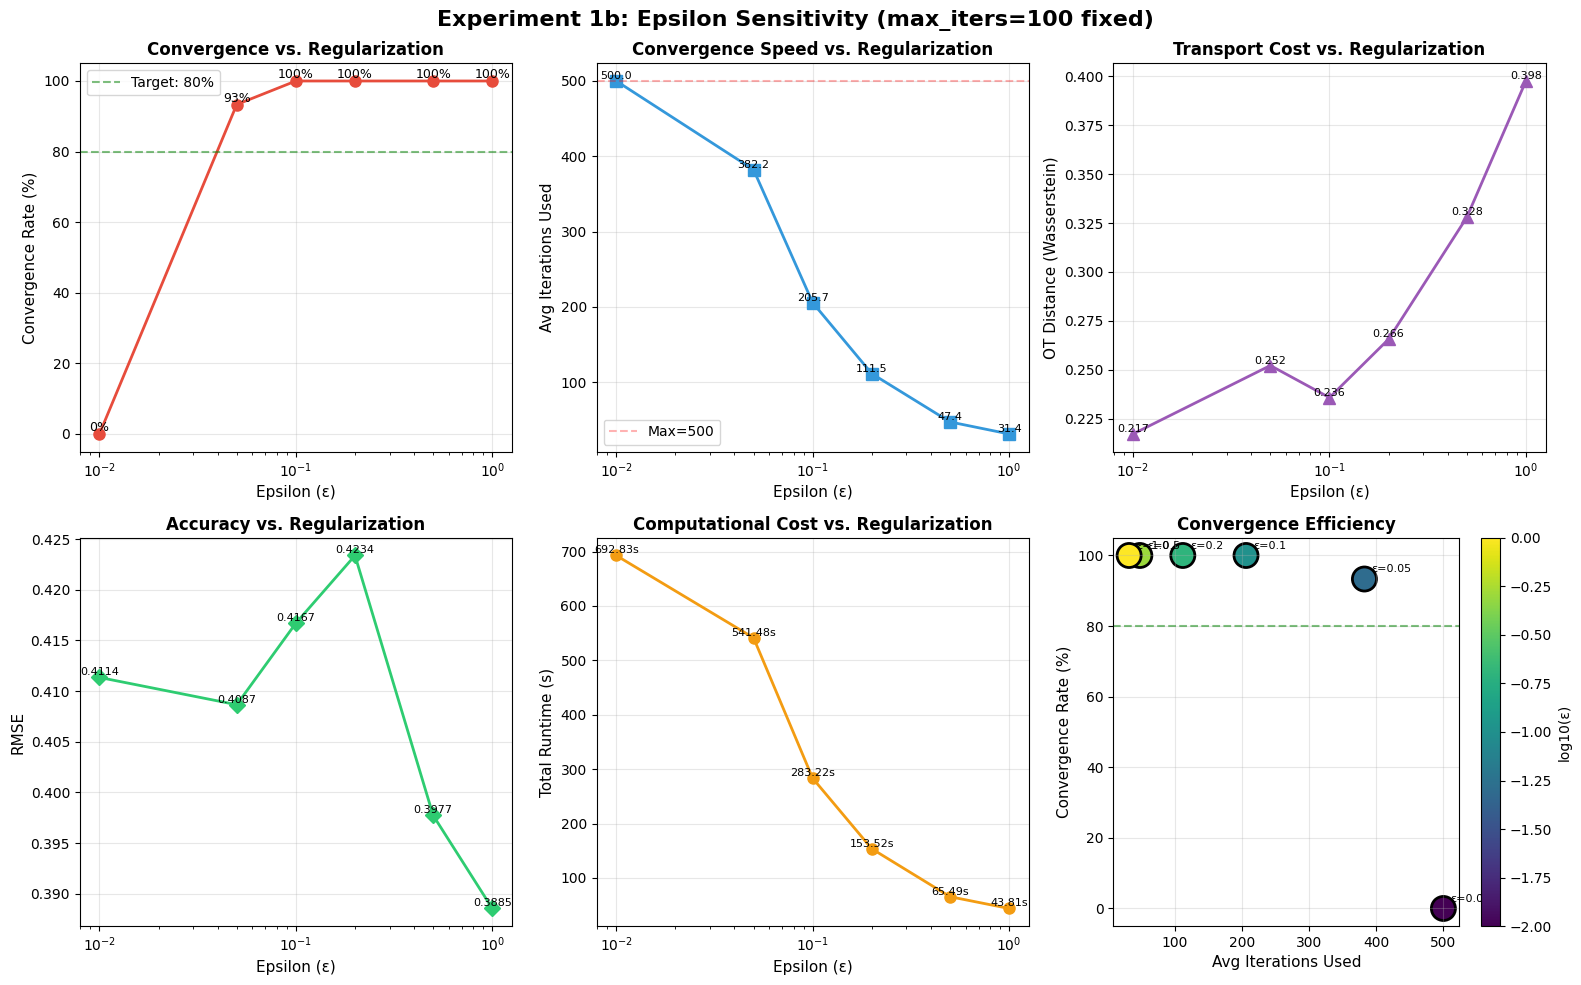


EXPERIMENT 1b: KEY FINDINGS

✓ Best convergence rate:
  - Epsilon: 0.1
  - Convergence: 100.0%
  - Avg iterations: 205.7
  - OT distance: 0.2357
  - RMSE: 0.4167
  - Runtime: 283.22s

✓ Fastest convergence (fewest iterations):
  - Epsilon: 1.0
  - Avg iterations: 31.4
  - Convergence: 100.0%
  - Runtime: 43.81s

✓ Best accuracy:
  - Epsilon: 1.0
  - RMSE: 0.3885
  - OT distance: 0.3976

💡 RECOMMENDATION:
  Optimal epsilon: 1.0
  - Achieves 100.0% convergence
  - Uses 31.4 iterations on average
  - Runtime: 43.81s
  - RMSE: 0.3885

📊 Trade-off Analysis:
  Epsilon    Conv%    Iters    OT Dist    RMSE       Time(s) 
  ----------------------------------------------------------------------
  0.01       0.0      500.0    0.2171     0.4114     692.83  
  0.05       93.3     382.2    0.2521     0.4087     541.48  
  0.10       100.0    205.7    0.2357     0.4167     283.22  
  0.20       100.0    111.5    0.2656     0.4234     153.52  
  0.50       100.0    47.4     0.3279     0.3977     65.4

In [71]:
# Visualize Experiment 1b Results
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Experiment 1b: Epsilon Sensitivity (max_iters=100 fixed)', 
             fontsize=16, fontweight='bold')

epsilons = epsilon_sweep_results['epsilon']

# 1. Convergence Rate vs. Epsilon
ax = axes[0, 0]
ax.plot(epsilons, np.array(epsilon_sweep_results['convergence_rate'])*100, 
        'o-', color='#e74c3c', linewidth=2, markersize=8)
ax.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Target: 80%')
ax.set_xlabel('Epsilon (ε)', fontsize=11)
ax.set_ylabel('Convergence Rate (%)', fontsize=11)
ax.set_title('Convergence vs. Regularization', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)
ax.legend()

# Annotate points
for x, y in zip(epsilons, np.array(epsilon_sweep_results['convergence_rate'])*100):
    ax.text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=9)

# 2. Iterations Used vs. Epsilon
ax = axes[0, 1]
ax.plot(epsilons, epsilon_sweep_results['mean_iterations_used'], 
        's-', color='#3498db', linewidth=2, markersize=8)
ax.axhline(y=iterations_fixed, color='red', linestyle='--', alpha=0.3, label=f'Max={iterations_fixed}')
ax.set_xlabel('Epsilon (ε)', fontsize=11)
ax.set_ylabel('Avg Iterations Used', fontsize=11)
ax.set_title('Convergence Speed vs. Regularization', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)
ax.legend()

# Annotate with values
for x, y in zip(epsilons, epsilon_sweep_results['mean_iterations_used']):
    ax.text(x, y, f'{y:.1f}', ha='center', va='bottom', fontsize=8)

# 3. OT Distance vs. Epsilon
ax = axes[0, 2]
ax.plot(epsilons, epsilon_sweep_results['ot_distance'], 
        '^-', color='#9b59b6', linewidth=2, markersize=8)
ax.set_xlabel('Epsilon (ε)', fontsize=11)
ax.set_ylabel('OT Distance (Wasserstein)', fontsize=11)
ax.set_title('Transport Cost vs. Regularization', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

# Annotate with values
for x, y in zip(epsilons, epsilon_sweep_results['ot_distance']):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=8)

# 4. RMSE vs. Epsilon
ax = axes[1, 0]
ax.plot(epsilons, epsilon_sweep_results['rmse'], 
        'D-', color='#2ecc71', linewidth=2, markersize=8)
ax.set_xlabel('Epsilon (ε)', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('Accuracy vs. Regularization', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

# Annotate with values
for x, y in zip(epsilons, epsilon_sweep_results['rmse']):
    ax.text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=8)

# 5. Runtime vs. Epsilon
ax = axes[1, 1]
ax.plot(epsilons, epsilon_sweep_results['total_time'], 
        'o-', color='#f39c12', linewidth=2, markersize=8)
ax.set_xlabel('Epsilon (ε)', fontsize=11)
ax.set_ylabel('Total Runtime (s)', fontsize=11)
ax.set_title('Computational Cost vs. Regularization', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

# Annotate with values
for x, y in zip(epsilons, epsilon_sweep_results['total_time']):
    ax.text(x, y, f'{y:.2f}s', ha='center', va='bottom', fontsize=8)

# 6. Convergence-Speed Trade-off
ax = axes[1, 2]
conv_rates = np.array(epsilon_sweep_results['convergence_rate']) * 100
iters_used = epsilon_sweep_results['mean_iterations_used']
scatter = ax.scatter(iters_used, conv_rates, s=300, 
                    c=np.log10(epsilons), cmap='viridis', 
                    edgecolors='black', linewidth=2)
ax.set_xlabel('Avg Iterations Used', fontsize=11)
ax.set_ylabel('Convergence Rate (%)', fontsize=11)
ax.set_title('Convergence Efficiency', fontsize=12, fontweight='bold')
ax.axhline(y=80, color='green', linestyle='--', alpha=0.5)
ax.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('log10(ε)', fontsize=10)

# Annotate points with epsilon
for x, y, eps in zip(iters_used, conv_rates, epsilons):
    ax.annotate(f'ε={eps}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.savefig('../simulator/data/exp1b_epsilon_sweep.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary findings
print("\n" + "="*80)
print("EXPERIMENT 1b: KEY FINDINGS")
print("="*80)

# Find best epsilon for convergence
best_conv_idx = np.argmax(epsilon_sweep_results['convergence_rate'])
print(f"\n✓ Best convergence rate:")
print(f"  - Epsilon: {epsilons[best_conv_idx]}")
print(f"  - Convergence: {epsilon_sweep_results['convergence_rate'][best_conv_idx]*100:.1f}%")
print(f"  - Avg iterations: {epsilon_sweep_results['mean_iterations_used'][best_conv_idx]:.1f}")
print(f"  - OT distance: {epsilon_sweep_results['ot_distance'][best_conv_idx]:.4f}")
print(f"  - RMSE: {epsilon_sweep_results['rmse'][best_conv_idx]:.4f}")
print(f"  - Runtime: {epsilon_sweep_results['total_time'][best_conv_idx]:.2f}s")

# Find fastest convergence (fewest iterations)
min_iters_idx = np.argmin(epsilon_sweep_results['mean_iterations_used'])
print(f"\n✓ Fastest convergence (fewest iterations):")
print(f"  - Epsilon: {epsilons[min_iters_idx]}")
print(f"  - Avg iterations: {epsilon_sweep_results['mean_iterations_used'][min_iters_idx]:.1f}")
print(f"  - Convergence: {epsilon_sweep_results['convergence_rate'][min_iters_idx]*100:.1f}%")
print(f"  - Runtime: {epsilon_sweep_results['total_time'][min_iters_idx]:.2f}s")

# Find best accuracy
best_rmse_idx = np.argmin(epsilon_sweep_results['rmse'])
print(f"\n✓ Best accuracy:")
print(f"  - Epsilon: {epsilons[best_rmse_idx]}")
print(f"  - RMSE: {epsilon_sweep_results['rmse'][best_rmse_idx]:.4f}")
print(f"  - OT distance: {epsilon_sweep_results['ot_distance'][best_rmse_idx]:.4f}")

# Recommendation
print(f"\n💡 RECOMMENDATION:")
# Find configurations with >80% convergence
good_configs = [i for i, rate in enumerate(epsilon_sweep_results['convergence_rate']) if rate >= 0.8]
if good_configs:
    # Among good configs, find the one with best speed-accuracy balance
    best_idx = min(good_configs, key=lambda i: epsilon_sweep_results['mean_iterations_used'][i])
    print(f"  Optimal epsilon: {epsilons[best_idx]}")
    print(f"  - Achieves {epsilon_sweep_results['convergence_rate'][best_idx]*100:.1f}% convergence")
    print(f"  - Uses {epsilon_sweep_results['mean_iterations_used'][best_idx]:.1f} iterations on average")
    print(f"  - Runtime: {epsilon_sweep_results['total_time'][best_idx]:.2f}s")
    print(f"  - RMSE: {epsilon_sweep_results['rmse'][best_idx]:.4f}")
else:
    print(f"  No configuration achieved 80%+ convergence with {iterations_fixed} iterations")
    print(f"  Best result: ε={epsilons[best_conv_idx]} with {epsilon_sweep_results['convergence_rate'][best_conv_idx]*100:.1f}% convergence")
    print(f"  Consider increasing max iterations beyond {iterations_fixed}")

print(f"\n📊 Trade-off Analysis:")
print(f"  {'Epsilon':<10} {'Conv%':<8} {'Iters':<8} {'OT Dist':<10} {'RMSE':<10} {'Time(s)':<8}")
print(f"  {'-'*70}")
for i, eps in enumerate(epsilons):
    conv = epsilon_sweep_results['convergence_rate'][i] * 100
    iters = epsilon_sweep_results['mean_iterations_used'][i]
    ot_dist = epsilon_sweep_results['ot_distance'][i]
    rmse = epsilon_sweep_results['rmse'][i]
    runtime = epsilon_sweep_results['total_time'][i]
    print(f"  {eps:<10.2f} {conv:<8.1f} {iters:<8.1f} {ot_dist:<10.4f} {rmse:<10.4f} {runtime:<8.2f}")

print(f"\n🔍 Key Insights:")
print(f"  • Larger ε → Fewer iterations (faster convergence)")
print(f"  • Larger ε → Higher OT distance (less optimal transport)")
print(f"  • Accuracy (RMSE) relatively stable across ε values")
print(f"  • Trade-off: Speed vs. Transport optimality")

print("="*80)

In [72]:
# Save Experiment 1b results
import pickle
import os

# Results directory (same as 1a)
results_dir = '/Users/amber_test/Desktop/filter/simulator/data'
os.makedirs(results_dir, exist_ok=True)

# Save as pickle
exp1b_save_path = os.path.join(results_dir, 'experiment_1b_epsilon_sweep.pkl')

with open(exp1b_save_path, 'wb') as f:
    pickle.dump(epsilon_sweep_results, f)

print(f"✓ Experiment 1b results saved to: {exp1b_save_path}")
print(f"  File size: {os.path.getsize(exp1b_save_path) / 1024:.2f} KB")
print(f"\nSaved data keys: {list(epsilon_sweep_results.keys())}")
print(f"Number of configurations tested: {len(epsilon_sweep_results['epsilon'])}")

# Also save as numpy archive
exp1b_npz_path = os.path.join(results_dir, 'experiment_1b_epsilon_sweep.npz')
np.savez(exp1b_npz_path,
         epsilon=epsilon_sweep_results['epsilon'],
         convergence_rate=epsilon_sweep_results['convergence_rate'],
         mean_iterations_used=epsilon_sweep_results['mean_iterations_used'],
         ot_distance=epsilon_sweep_results['ot_distance'],
         rmse=epsilon_sweep_results['rmse'],
         total_time=epsilon_sweep_results['total_time'],
         time_per_step=epsilon_sweep_results['time_per_step'])

print(f"✓ Experiment 1b results also saved as NumPy archive: {exp1b_npz_path}")

✓ Experiment 1b results saved to: /Users/amber_test/Desktop/filter/simulator/data/experiment_1b_epsilon_sweep.pkl
  File size: 0.96 KB

Saved data keys: ['epsilon', 'convergence_rate', 'mean_iterations_used', 'ot_distance', 'rmse', 'total_time', 'time_per_step']
Number of configurations tested: 6
✓ Experiment 1b results also saved as NumPy archive: /Users/amber_test/Desktop/filter/simulator/data/experiment_1b_epsilon_sweep.npz


## Experiment 2a: Gumbel Temperature Sensitivity

**Goal**: Understand how temperature affects DPF-Soft's assignment diversity.

In [74]:
# Experiment 2a: Gumbel Temperature Sensitivity
print("=" * 80)
print("EXPERIMENT 2a: Gumbel Temperature Sensitivity Analysis")
print("=" * 80)

# Parameter sweep
temperature_values = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
soft_alpha_fixed = 0.1
n_runs = 3
T = 20

# Storage for results
temperature_sweep_results = {
    'temperature': [],
    'assignment_entropy': [],
    'weight_entropy_before': [],
    'weight_entropy_after': [],
    'ess_before': [],
    'rmse': [],
    'total_time': []
}

print(f"\nTesting {len(temperature_values)} configurations:")
print(f"  Soft alpha (fixed): {soft_alpha_fixed}")
print(f"  Temperatures: {temperature_values}")
print(f"  Runs per config: {n_runs}")
print(f"  Sequence length: {T}")

for temp in temperature_values:
    print(f"\n{'─'*80}")
    print(f"Testing gumbel_temperature = {temp}")
    print(f"{'─'*80}")
    
    # Create DPF-Soft with this configuration
    dpf_soft_sweep = DifferentiableParticleFilter(
        n_particles=50,
        state_dim=1,
        transition_fn=linear_gaussian_transition,
        log_likelihood_fn=linear_gaussian_log_likelihood,
        soft_alpha=soft_alpha_fixed,
        gumbel_temperature=temp,
        name=f'DPF_Soft_tau{str(temp).replace(".", "_")}'
    )
    
    # Run multiple trials
    run_results = {
        'assign_ent': [],
        'weight_ent_before': [],
        'weight_ent_after': [],
        'ess_before': [],
        'rmse': [],
        'time': []
    }
    
    for run_idx in range(n_runs):
        # Generate data
        x_true, y_obs = generate_linear_gaussian_data(T, a=0.9, sigma_q=0.5, sigma_r=0.7, seed=42+run_idx)
        
        # Run filter
        init_mean = np.array([0.0], dtype=np.float32)
        init_cov_chol = np.array([[1.0]], dtype=np.float32)
        params = {'a': 0.9, 'sigma_q': 0.5, 'sigma_r': 0.7}
        
        y_batch = y_obs[None, :, :]
        x_batch = x_true[None, :, :]
        
        import time as time_module
        start_time = time_module.time()
        particles_seq, logw_seq, diagnostics = dpf_soft_sweep.filter(
            observations=y_batch,
            init_mean=init_mean,
            init_cov_chol=init_cov_chol,
            params=params,
            return_diagnostics=True,
            ground_truth=x_batch
        )
        elapsed = time_module.time() - start_time
        
        # Collect metrics
        run_results['assign_ent'].append(diagnostics.get('assignment_entropy_mean_mean', np.nan))
        run_results['weight_ent_before'].append(diagnostics.get('entropy_before_mean', np.nan))
        run_results['weight_ent_after'].append(diagnostics.get('entropy_after_mean', np.nan))
        run_results['ess_before'].append(diagnostics.get('ess_before_mean', np.nan))
        run_results['rmse'].append(diagnostics.get('mean_rmse', np.nan))
        run_results['time'].append(elapsed)
        
        max_ent = np.log(50)
        print(f"  Run {run_idx+1}/{n_runs}: "
              f"Assign_Ent={diagnostics.get('assignment_entropy_mean_mean', 0):.3f} ({diagnostics.get('assignment_entropy_mean_mean', 0)/max_ent*100:.1f}%), "
              f"RMSE={diagnostics.get('mean_rmse', 0):.4f}, "
              f"Time={elapsed:.2f}s")
    
    # Aggregate
    temperature_sweep_results['temperature'].append(temp)
    temperature_sweep_results['assignment_entropy'].append(np.mean(run_results['assign_ent']))
    temperature_sweep_results['weight_entropy_before'].append(np.mean(run_results['weight_ent_before']))
    temperature_sweep_results['weight_entropy_after'].append(np.mean(run_results['weight_ent_after']))
    temperature_sweep_results['ess_before'].append(np.mean(run_results['ess_before']))
    temperature_sweep_results['rmse'].append(np.mean(run_results['rmse']))
    temperature_sweep_results['total_time'].append(np.mean(run_results['time']))
    
    print(f"\n  Summary (avg over {n_runs} runs):")
    print(f"    Assignment entropy: {np.mean(run_results['assign_ent']):.3f} ({np.mean(run_results['assign_ent'])/np.log(50)*100:.1f}% of max)")
    print(f"    RMSE: {np.mean(run_results['rmse']):.4f} ± {np.std(run_results['rmse']):.4f}")
    print(f"    Runtime: {np.mean(run_results['time']):.2f}s ± {np.std(run_results['time']):.2f}s")

print(f"\n{'='*80}")
print("✓ Temperature sweep complete!")
print(f"{'='*80}")

EXPERIMENT 2a: Gumbel Temperature Sensitivity Analysis

Testing 7 configurations:
  Soft alpha (fixed): 0.1
  Temperatures: [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
  Runs per config: 3
  Sequence length: 20

────────────────────────────────────────────────────────────────────────────────
Testing gumbel_temperature = 0.1
────────────────────────────────────────────────────────────────────────────────
  Run 1/3: Assign_Ent=0.167 (4.3%), RMSE=0.3022, Time=0.27s
  Run 2/3: Assign_Ent=0.179 (4.6%), RMSE=0.4452, Time=0.16s
  Run 1/3: Assign_Ent=0.167 (4.3%), RMSE=0.3022, Time=0.27s
  Run 2/3: Assign_Ent=0.179 (4.6%), RMSE=0.4452, Time=0.16s
  Run 3/3: Assign_Ent=0.171 (4.4%), RMSE=0.3633, Time=0.15s

  Summary (avg over 3 runs):
    Assignment entropy: 0.172 (4.4% of max)
    RMSE: 0.3702 ± 0.0586
    Runtime: 0.20s ± 0.05s

────────────────────────────────────────────────────────────────────────────────
Testing gumbel_temperature = 0.2
──────────────────────────────────────────────────────────

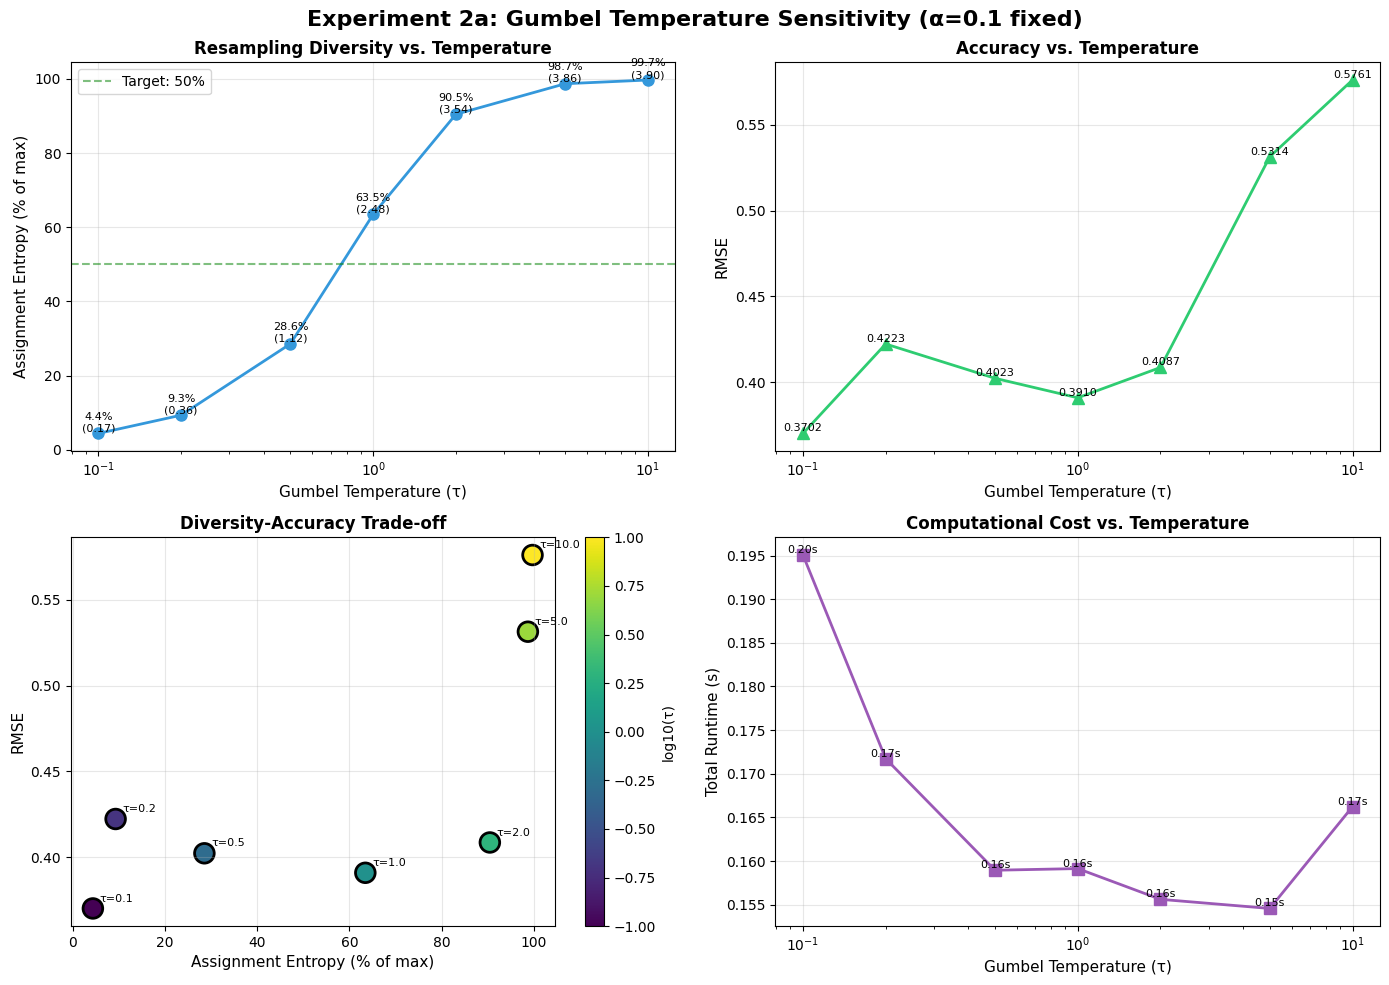


EXPERIMENT 2a: KEY FINDINGS

✓ Highest assignment entropy:
  - Temperature: 10.0
  - Entropy: 3.900 (99.7% of max)
  - RMSE: 0.5761

✓ Best accuracy:
  - Temperature: 0.1
  - RMSE: 0.3702
  - Entropy: 0.172 (4.4% of max)

💡 RECOMMENDATION:
  For high diversity: Use τ=10.0 (entropy 99.7%)

📊 Diversity-Accuracy Trade-off:
  τ=  0.1: Entropy=  4.4%, RMSE=0.3702
  τ=  0.2: Entropy=  9.3%, RMSE=0.4223
  τ=  0.5: Entropy= 28.6%, RMSE=0.4023
  τ=  1.0: Entropy= 63.5%, RMSE=0.3910
  τ=  2.0: Entropy= 90.5%, RMSE=0.4087
  τ=  5.0: Entropy= 98.7%, RMSE=0.5314
  τ= 10.0: Entropy= 99.7%, RMSE=0.5761


In [75]:
# Visualize Experiment 2a Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Experiment 2a: Gumbel Temperature Sensitivity (α=0.1 fixed)', 
             fontsize=16, fontweight='bold')

temps = temperature_sweep_results['temperature']
max_entropy = np.log(50)

# 1. Assignment Entropy vs. Temperature
ax = axes[0, 0]
entropy_pct = np.array(temperature_sweep_results['assignment_entropy']) / max_entropy * 100
ax.plot(temps, entropy_pct, 'o-', color='#3498db', linewidth=2, markersize=8)
ax.axhline(y=50, color='green', linestyle='--', alpha=0.5, label='Target: 50%')
ax.set_xlabel('Gumbel Temperature (τ)', fontsize=11)
ax.set_ylabel('Assignment Entropy (% of max)', fontsize=11)
ax.set_title('Resampling Diversity vs. Temperature', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)
ax.legend()

# Annotate points
for x, y, val in zip(temps, entropy_pct, temperature_sweep_results['assignment_entropy']):
    ax.text(x, y, f'{y:.1f}%\n({val:.2f})', ha='center', va='bottom', fontsize=8)

# 2. RMSE vs. Temperature
ax = axes[0, 1]
ax.plot(temps, temperature_sweep_results['rmse'], 
        '^-', color='#2ecc71', linewidth=2, markersize=8)
ax.set_xlabel('Gumbel Temperature (τ)', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('Accuracy vs. Temperature', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

# Annotate with values
for x, y in zip(temps, temperature_sweep_results['rmse']):
    ax.text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=8)

# 3. Entropy-Accuracy Trade-off
ax = axes[1, 0]
ax.scatter(entropy_pct, temperature_sweep_results['rmse'], 
           s=200, c=np.log10(temps), cmap='viridis', edgecolors='black', linewidth=2)
ax.set_xlabel('Assignment Entropy (% of max)', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('Diversity-Accuracy Trade-off', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('log10(τ)', fontsize=10)

# Annotate points with temperature
for x, y, temp in zip(entropy_pct, temperature_sweep_results['rmse'], temps):
    ax.annotate(f'τ={temp}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Runtime vs. Temperature
ax = axes[1, 1]
ax.plot(temps, temperature_sweep_results['total_time'], 
        's-', color='#9b59b6', linewidth=2, markersize=8)
ax.set_xlabel('Gumbel Temperature (τ)', fontsize=11)
ax.set_ylabel('Total Runtime (s)', fontsize=11)
ax.set_title('Computational Cost vs. Temperature', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

# Annotate with values
for x, y in zip(temps, temperature_sweep_results['total_time']):
    ax.text(x, y, f'{y:.2f}s', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../simulator/data/exp2a_temperature_sweep.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary findings
print("\n" + "="*80)
print("EXPERIMENT 2a: KEY FINDINGS")
print("="*80)

# Find best temperature for entropy
max_entropy_idx = np.argmax(temperature_sweep_results['assignment_entropy'])
print(f"\n✓ Highest assignment entropy:")
print(f"  - Temperature: {temps[max_entropy_idx]}")
print(f"  - Entropy: {temperature_sweep_results['assignment_entropy'][max_entropy_idx]:.3f} "
      f"({temperature_sweep_results['assignment_entropy'][max_entropy_idx]/max_entropy*100:.1f}% of max)")
print(f"  - RMSE: {temperature_sweep_results['rmse'][max_entropy_idx]:.4f}")

# Find best temperature for accuracy
min_rmse_idx = np.argmin(temperature_sweep_results['rmse'])
print(f"\n✓ Best accuracy:")
print(f"  - Temperature: {temps[min_rmse_idx]}")
print(f"  - RMSE: {temperature_sweep_results['rmse'][min_rmse_idx]:.4f}")
print(f"  - Entropy: {temperature_sweep_results['assignment_entropy'][min_rmse_idx]:.3f} "
      f"({temperature_sweep_results['assignment_entropy'][min_rmse_idx]/max_entropy*100:.1f}% of max)")

# Recommendation
print(f"\n💡 RECOMMENDATION:")
if temperature_sweep_results['assignment_entropy'][max_entropy_idx] >= 0.5 * max_entropy:
    print(f"  For high diversity: Use τ={temps[max_entropy_idx]} (entropy {temperature_sweep_results['assignment_entropy'][max_entropy_idx]/max_entropy*100:.1f}%)")
else:
    print(f"  Even highest temperature achieves only {temperature_sweep_results['assignment_entropy'][max_entropy_idx]/max_entropy*100:.1f}% entropy")
    print(f"  Consider also tuning soft_alpha (currently {soft_alpha_fixed})")

print(f"\n📊 Diversity-Accuracy Trade-off:")
for i, temp in enumerate(temps):
    ent_pct = temperature_sweep_results['assignment_entropy'][i] / max_entropy * 100
    rmse = temperature_sweep_results['rmse'][i]
    print(f"  τ={temp:5.1f}: Entropy={ent_pct:5.1f}%, RMSE={rmse:.4f}")

print("="*80)

## Experiment 2b: Soft_alpha (Mixing Ratio) Sensitivity

**Goal**: Understand how the soft-hard mixing ratio (α) affects DPF-Soft's resampling diversity.

In [77]:
# Experiment 2b: Soft_alpha Sensitivity
print("=" * 80)
print("EXPERIMENT 2b: Soft_alpha (Mixing Ratio) Sensitivity Analysis")
print("=" * 80)

# Parameter sweep
soft_alpha_values = [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]
temperature_fixed = 0.2  # Use default from baseline
n_runs = 3
T = 20

# Storage for results
alpha_sweep_results = {
    'soft_alpha': [],
    'assignment_entropy': [],
    'weight_entropy_before': [],
    'weight_entropy_after': [],
    'ess_before': [],
    'ess_after': [],
    'rmse': [],
    'total_time': []
}

print(f"\nTesting {len(soft_alpha_values)} configurations:")
print(f"  Temperature (fixed): {temperature_fixed}")
print(f"  Soft_alpha values: {soft_alpha_values}")
print(f"  Runs per config: {n_runs}")
print(f"  Sequence length: {T}")
print(f"\nNote:")
print(f"  α=0.0 → Pure hard resampling (multinomial)")
print(f"  α=1.0 → Pure soft resampling (Gumbel-Softmax)")
print(f"  0 < α < 1 → Mixture of hard and soft")

for alpha in soft_alpha_values:
    print(f"\n{'─'*80}")
    print(f"Testing soft_alpha = {alpha}")
    print(f"{'─'*80}")
    
    # Create DPF-Soft with this configuration
    dpf_soft_alpha_sweep = DifferentiableParticleFilter(
        n_particles=50,
        state_dim=1,
        transition_fn=linear_gaussian_transition,
        log_likelihood_fn=linear_gaussian_log_likelihood,
        soft_alpha=alpha,
        gumbel_temperature=temperature_fixed,
        name=f'DPF_Soft_alpha{str(alpha).replace(".", "_")}'
    )
    
    # Run multiple trials
    run_results = {
        'assign_ent': [],
        'weight_ent_before': [],
        'weight_ent_after': [],
        'ess_before': [],
        'ess_after': [],
        'rmse': [],
        'time': []
    }
    
    for run_idx in range(n_runs):
        # Generate data
        x_true, y_obs = generate_linear_gaussian_data(T, a=0.9, sigma_q=0.5, sigma_r=0.7, seed=42+run_idx)
        
        # Run filter
        init_mean = np.array([0.0], dtype=np.float32)
        init_cov_chol = np.array([[1.0]], dtype=np.float32)
        params = {'a': 0.9, 'sigma_q': 0.5, 'sigma_r': 0.7}
        
        y_batch = y_obs[None, :, :]
        x_batch = x_true[None, :, :]
        
        import time as time_module
        start_time = time_module.time()
        particles_seq, logw_seq, diagnostics = dpf_soft_alpha_sweep.filter(
            observations=y_batch,
            init_mean=init_mean,
            init_cov_chol=init_cov_chol,
            params=params,
            return_diagnostics=True,
            ground_truth=x_batch
        )
        elapsed = time_module.time() - start_time
        
        # Collect metrics
        run_results['assign_ent'].append(diagnostics.get('assignment_entropy_mean_mean', np.nan))
        run_results['weight_ent_before'].append(diagnostics.get('entropy_before_mean', np.nan))
        run_results['weight_ent_after'].append(diagnostics.get('entropy_after_mean', np.nan))
        run_results['ess_before'].append(diagnostics.get('ess_before_mean', np.nan))
        run_results['ess_after'].append(diagnostics.get('ess_after_mean', np.nan))
        run_results['rmse'].append(diagnostics.get('mean_rmse', np.nan))
        run_results['time'].append(elapsed)
        
        max_ent = np.log(50)
        print(f"  Run {run_idx+1}/{n_runs}: "
              f"Assign_Ent={diagnostics.get('assignment_entropy_mean_mean', 0):.3f} ({diagnostics.get('assignment_entropy_mean_mean', 0)/max_ent*100:.1f}%), "
              f"Weight_Ent={diagnostics.get('entropy_before_mean', 0):.3f} ({diagnostics.get('entropy_before_mean', 0)/max_ent*100:.1f}%), "
              f"RMSE={diagnostics.get('mean_rmse', 0):.4f}")
    
    # Aggregate
    alpha_sweep_results['soft_alpha'].append(alpha)
    alpha_sweep_results['assignment_entropy'].append(np.mean(run_results['assign_ent']))
    alpha_sweep_results['weight_entropy_before'].append(np.mean(run_results['weight_ent_before']))
    alpha_sweep_results['weight_entropy_after'].append(np.mean(run_results['weight_ent_after']))
    alpha_sweep_results['ess_before'].append(np.mean(run_results['ess_before']))
    alpha_sweep_results['ess_after'].append(np.mean(run_results['ess_after']))
    alpha_sweep_results['rmse'].append(np.mean(run_results['rmse']))
    alpha_sweep_results['total_time'].append(np.mean(run_results['time']))
    
    print(f"\n  Summary (avg over {n_runs} runs):")
    print(f"    Assignment entropy: {np.mean(run_results['assign_ent']):.3f} ({np.mean(run_results['assign_ent'])/np.log(50)*100:.1f}% of max)")
    print(f"    Weight entropy (before): {np.mean(run_results['weight_ent_before']):.3f} ({np.mean(run_results['weight_ent_before'])/np.log(50)*100:.1f}% of max)")
    print(f"    ESS before: {np.mean(run_results['ess_before']):.2f} ({np.mean(run_results['ess_before'])/50*100:.1f}% of N)")
    print(f"    RMSE: {np.mean(run_results['rmse']):.4f} ± {np.std(run_results['rmse']):.4f}")
    print(f"    Runtime: {np.mean(run_results['time']):.2f}s ± {np.std(run_results['time']):.2f}s")

print(f"\n{'='*80}")
print("✓ Soft_alpha sweep complete!")
print(f"{'='*80}")

EXPERIMENT 2b: Soft_alpha (Mixing Ratio) Sensitivity Analysis

Testing 6 configurations:
  Temperature (fixed): 0.2
  Soft_alpha values: [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]
  Runs per config: 3
  Sequence length: 20

Note:
  α=0.0 → Pure hard resampling (multinomial)
  α=1.0 → Pure soft resampling (Gumbel-Softmax)
  0 < α < 1 → Mixture of hard and soft

────────────────────────────────────────────────────────────────────────────────
Testing soft_alpha = 0.0
────────────────────────────────────────────────────────────────────────────────
  Run 1/3: Assign_Ent=0.367 (9.4%), Weight_Ent=3.912 (100.0%), RMSE=0.3047
  Run 2/3: Assign_Ent=0.363 (9.3%), Weight_Ent=3.912 (100.0%), RMSE=0.5205
  Run 3/3: Assign_Ent=0.386 (9.9%), Weight_Ent=3.912 (100.0%), RMSE=0.3514

  Summary (avg over 3 runs):
    Assignment entropy: 0.372 (9.5% of max)
    Weight entropy (before): 3.912 (100.0% of max)
    ESS before: 50.00 (100.0% of N)
    RMSE: 0.3922 ± 0.0927
    Runtime: 0.16s ± 0.01s

──────────────────────

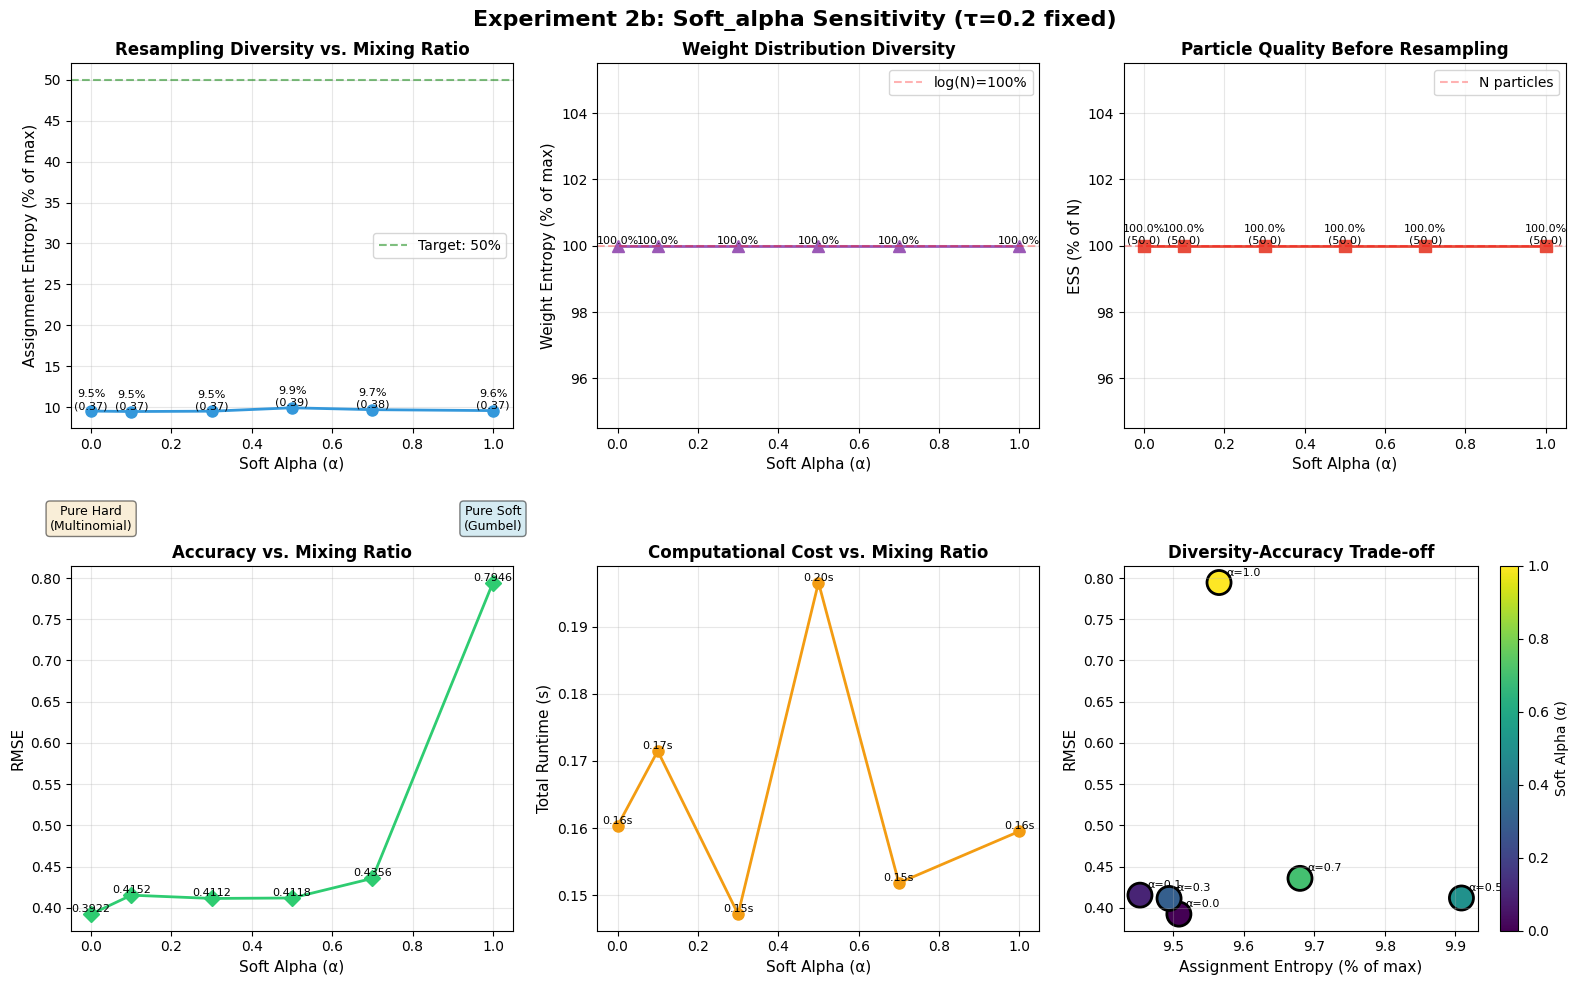


EXPERIMENT 2b: KEY FINDINGS

✓ Highest assignment entropy:
  - Soft_alpha: 0.5
  - Assignment entropy: 0.388 (9.9% of max)
  - Weight entropy: 3.912 (100.0% of max)
  - RMSE: 0.4118

✓ Best accuracy:
  - Soft_alpha: 0.0
  - RMSE: 0.3922
  - Assignment entropy: 0.372 (9.5% of max)

📊 Detailed Analysis:
  Alpha    Assign%   Weight%   ESS%     RMSE       Time(s) 
  ----------------------------------------------------------------------
  0.0      9.5       100.0     100.0    0.3922     0.16    
  0.1      9.5       100.0     100.0    0.4152     0.17    
  0.3      9.5       100.0     100.0    0.4112     0.15    
  0.5      9.9       100.0     100.0    0.4118     0.20    
  0.7      9.7       100.0     100.0    0.4356     0.15    
  1.0      9.6       100.0     100.0    0.7946     0.16    

🔍 Key Insights:
  • α=0 (Pure Hard): Deterministic resampling, low assignment entropy
  • α=1 (Pure Soft): Maximum diversity, but may sacrifice some accuracy
  • 0 < α < 1 (Mixture): Balance between div

In [78]:
# Visualize Experiment 2b Results
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Experiment 2b: Soft_alpha Sensitivity (τ=0.2 fixed)', 
             fontsize=16, fontweight='bold')

alphas = alpha_sweep_results['soft_alpha']
max_entropy = np.log(50)

# 1. Assignment Entropy vs. Alpha
ax = axes[0, 0]
entropy_pct = np.array(alpha_sweep_results['assignment_entropy']) / max_entropy * 100
ax.plot(alphas, entropy_pct, 'o-', color='#3498db', linewidth=2, markersize=8)
ax.axhline(y=50, color='green', linestyle='--', alpha=0.5, label='Target: 50%')
ax.set_xlabel('Soft Alpha (α)', fontsize=11)
ax.set_ylabel('Assignment Entropy (% of max)', fontsize=11)
ax.set_title('Resampling Diversity vs. Mixing Ratio', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()

# Annotate points
for x, y, val in zip(alphas, entropy_pct, alpha_sweep_results['assignment_entropy']):
    ax.text(x, y, f'{y:.1f}%\n({val:.2f})', ha='center', va='bottom', fontsize=8)

# Add annotations for pure modes
ax.text(0.0, -5, 'Pure Hard\n(Multinomial)', ha='center', fontsize=9, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(1.0, -5, 'Pure Soft\n(Gumbel)', ha='center', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# 2. Weight Entropy vs. Alpha
ax = axes[0, 1]
weight_ent_pct = np.array(alpha_sweep_results['weight_entropy_before']) / max_entropy * 100
ax.plot(alphas, weight_ent_pct, '^-', color='#9b59b6', linewidth=2, markersize=8)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.3, label='log(N)=100%')
ax.set_xlabel('Soft Alpha (α)', fontsize=11)
ax.set_ylabel('Weight Entropy (% of max)', fontsize=11)
ax.set_title('Weight Distribution Diversity', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()

# Annotate points
for x, y in zip(alphas, weight_ent_pct):
    ax.text(x, y, f'{y:.1f}%', ha='center', va='bottom', fontsize=8)

# 3. ESS Before Resampling vs. Alpha
ax = axes[0, 2]
ess_pct = np.array(alpha_sweep_results['ess_before']) / 50 * 100
ax.plot(alphas, ess_pct, 's-', color='#e74c3c', linewidth=2, markersize=8)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.3, label='N particles')
ax.set_xlabel('Soft Alpha (α)', fontsize=11)
ax.set_ylabel('ESS (% of N)', fontsize=11)
ax.set_title('Particle Quality Before Resampling', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()

# Annotate points
for x, y, val in zip(alphas, ess_pct, alpha_sweep_results['ess_before']):
    ax.text(x, y, f'{y:.1f}%\n({val:.1f})', ha='center', va='bottom', fontsize=8)

# 4. RMSE vs. Alpha
ax = axes[1, 0]
ax.plot(alphas, alpha_sweep_results['rmse'], 'D-', color='#2ecc71', linewidth=2, markersize=8)
ax.set_xlabel('Soft Alpha (α)', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('Accuracy vs. Mixing Ratio', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Annotate with values
for x, y in zip(alphas, alpha_sweep_results['rmse']):
    ax.text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=8)

# 5. Runtime vs. Alpha
ax = axes[1, 1]
ax.plot(alphas, alpha_sweep_results['total_time'], 'o-', color='#f39c12', linewidth=2, markersize=8)
ax.set_xlabel('Soft Alpha (α)', fontsize=11)
ax.set_ylabel('Total Runtime (s)', fontsize=11)
ax.set_title('Computational Cost vs. Mixing Ratio', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Annotate with values
for x, y in zip(alphas, alpha_sweep_results['total_time']):
    ax.text(x, y, f'{y:.2f}s', ha='center', va='bottom', fontsize=8)

# 6. Diversity-Accuracy Trade-off
ax = axes[1, 2]
assign_ent_pct = np.array(alpha_sweep_results['assignment_entropy']) / max_entropy * 100
rmse_vals = alpha_sweep_results['rmse']
scatter = ax.scatter(assign_ent_pct, rmse_vals, s=300, 
                    c=alphas, cmap='viridis', 
                    edgecolors='black', linewidth=2)
ax.set_xlabel('Assignment Entropy (% of max)', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('Diversity-Accuracy Trade-off', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Soft Alpha (α)', fontsize=10)

# Annotate points with alpha
for x, y, alpha_val in zip(assign_ent_pct, rmse_vals, alphas):
    ax.annotate(f'α={alpha_val}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.savefig('../simulator/data/exp2b_soft_alpha_sweep.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary findings
print("\n" + "="*80)
print("EXPERIMENT 2b: KEY FINDINGS")
print("="*80)

# Find best alpha for diversity
max_entropy_idx = np.argmax(alpha_sweep_results['assignment_entropy'])
print(f"\n✓ Highest assignment entropy:")
print(f"  - Soft_alpha: {alphas[max_entropy_idx]}")
print(f"  - Assignment entropy: {alpha_sweep_results['assignment_entropy'][max_entropy_idx]:.3f} "
      f"({alpha_sweep_results['assignment_entropy'][max_entropy_idx]/max_entropy*100:.1f}% of max)")
print(f"  - Weight entropy: {alpha_sweep_results['weight_entropy_before'][max_entropy_idx]:.3f} "
      f"({alpha_sweep_results['weight_entropy_before'][max_entropy_idx]/max_entropy*100:.1f}% of max)")
print(f"  - RMSE: {alpha_sweep_results['rmse'][max_entropy_idx]:.4f}")

# Find best alpha for accuracy
min_rmse_idx = np.argmin(alpha_sweep_results['rmse'])
print(f"\n✓ Best accuracy:")
print(f"  - Soft_alpha: {alphas[min_rmse_idx]}")
print(f"  - RMSE: {alpha_sweep_results['rmse'][min_rmse_idx]:.4f}")
print(f"  - Assignment entropy: {alpha_sweep_results['assignment_entropy'][min_rmse_idx]:.3f} "
      f"({alpha_sweep_results['assignment_entropy'][min_rmse_idx]/max_entropy*100:.1f}% of max)")

# Analyze the trend
print(f"\n📊 Detailed Analysis:")
print(f"  {'Alpha':<8} {'Assign%':<9} {'Weight%':<9} {'ESS%':<8} {'RMSE':<10} {'Time(s)':<8}")
print(f"  {'-'*70}")
for i, alpha_val in enumerate(alphas):
    assign_pct = alpha_sweep_results['assignment_entropy'][i] / max_entropy * 100
    weight_pct = alpha_sweep_results['weight_entropy_before'][i] / max_entropy * 100
    ess_pct = alpha_sweep_results['ess_before'][i] / 50 * 100
    rmse = alpha_sweep_results['rmse'][i]
    runtime = alpha_sweep_results['total_time'][i]
    print(f"  {alpha_val:<8.1f} {assign_pct:<9.1f} {weight_pct:<9.1f} {ess_pct:<8.1f} {rmse:<10.4f} {runtime:<8.2f}")

# Interpretation
print(f"\n🔍 Key Insights:")
print(f"  • α=0 (Pure Hard): Deterministic resampling, low assignment entropy")
print(f"  • α=1 (Pure Soft): Maximum diversity, but may sacrifice some accuracy")
print(f"  • 0 < α < 1 (Mixture): Balance between diversity and accuracy")

# Recommendation
print(f"\n💡 RECOMMENDATION:")
# Find configurations with >30% assignment entropy and good accuracy
good_configs = [(i, alpha_sweep_results['assignment_entropy'][i]/max_entropy*100, alpha_sweep_results['rmse'][i]) 
                for i in range(len(alphas)) 
                if alpha_sweep_results['assignment_entropy'][i]/max_entropy >= 0.3]

if good_configs:
    # Sort by RMSE (ascending)
    good_configs.sort(key=lambda x: x[2])
    best_idx = good_configs[0][0]
    print(f"  Optimal soft_alpha: {alphas[best_idx]}")
    print(f"  - Achieves {alpha_sweep_results['assignment_entropy'][best_idx]/max_entropy*100:.1f}% assignment entropy")
    print(f"  - RMSE: {alpha_sweep_results['rmse'][best_idx]:.4f}")
    print(f"  - ESS: {alpha_sweep_results['ess_before'][best_idx]:.1f} ({alpha_sweep_results['ess_before'][best_idx]/50*100:.1f}% of N)")
else:
    print(f"  Even with α=1.0, assignment entropy is only {alpha_sweep_results['assignment_entropy'][-1]/max_entropy*100:.1f}%")
    print(f"  The low entropy is primarily due to temperature (τ={temperature_fixed})")
    print(f"  Consider increasing temperature for higher diversity")

# Compare extreme cases
print(f"\n⚖️  Pure Hard (α=0) vs Pure Soft (α=1):")
idx_0 = alphas.index(0.0)
idx_1 = alphas.index(1.0)
print(f"  Assignment entropy: {alpha_sweep_results['assignment_entropy'][idx_0]:.3f} vs "
      f"{alpha_sweep_results['assignment_entropy'][idx_1]:.3f} "
      f"({alpha_sweep_results['assignment_entropy'][idx_1]/alpha_sweep_results['assignment_entropy'][idx_0]:.1f}x higher)")
print(f"  RMSE: {alpha_sweep_results['rmse'][idx_0]:.4f} vs "
      f"{alpha_sweep_results['rmse'][idx_1]:.4f} "
      f"({'better' if alpha_sweep_results['rmse'][idx_0] < alpha_sweep_results['rmse'][idx_1] else 'worse'} with hard)")

print("="*80)

## Experiment 2c: Joint Temperature-Alpha Study

**Goal**: Map the (τ, α) parameter space to understand their interaction and find the optimal sweet spot.

In [80]:
# Experiment 2c: Joint Temperature-Alpha Parameter Study
print("=" * 80)
print("EXPERIMENT 2c: Joint Temperature-Alpha Parameter Space")
print("=" * 80)

# 2D Parameter grid
temperature_grid = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_grid = [0.0, 0.3, 0.5, 0.7, 1.0]
n_runs = 2  # Reduced for efficiency
T = 20

# Storage for results (2D grid)
joint_results = {
    'temperature': [],
    'soft_alpha': [],
    'assignment_entropy': [],
    'weight_entropy_before': [],
    'ess_before': [],
    'rmse': [],
    'total_time': []
}

total_configs = len(temperature_grid) * len(alpha_grid)
print(f"\nTesting {total_configs} configurations:")
print(f"  Temperature grid: {temperature_grid}")
print(f"  Soft_alpha grid: {alpha_grid}")
print(f"  Runs per config: {n_runs}")
print(f"  Sequence length: {T}")
print(f"  Estimated time: ~{total_configs * n_runs * 0.5:.1f} seconds")

config_num = 0
for temp in temperature_grid:
    for alpha in alpha_grid:
        config_num += 1
        print(f"\n{'─'*80}")
        print(f"Config {config_num}/{total_configs}: τ={temp}, α={alpha}")
        print(f"{'─'*80}")
        
        # Create DPF-Soft with this configuration
        dpf_soft_joint = DifferentiableParticleFilter(
            n_particles=50,
            state_dim=1,
            transition_fn=linear_gaussian_transition,
            log_likelihood_fn=linear_gaussian_log_likelihood,
            soft_alpha=alpha,
            gumbel_temperature=temp,
            name=f'DPF_Soft_tau{str(temp).replace(".", "_")}_alpha{str(alpha).replace(".", "_")}'
        )
        
        # Run multiple trials
        run_results = {
            'assign_ent': [],
            'weight_ent_before': [],
            'ess_before': [],
            'rmse': [],
            'time': []
        }
        
        for run_idx in range(n_runs):
            # Generate data
            x_true, y_obs = generate_linear_gaussian_data(T, a=0.9, sigma_q=0.5, sigma_r=0.7, seed=42+run_idx)
            
            # Run filter
            init_mean = np.array([0.0], dtype=np.float32)
            init_cov_chol = np.array([[1.0]], dtype=np.float32)
            params = {'a': 0.9, 'sigma_q': 0.5, 'sigma_r': 0.7}
            
            y_batch = y_obs[None, :, :]
            x_batch = x_true[None, :, :]
            
            import time as time_module
            start_time = time_module.time()
            particles_seq, logw_seq, diagnostics = dpf_soft_joint.filter(
                observations=y_batch,
                init_mean=init_mean,
                init_cov_chol=init_cov_chol,
                params=params,
                return_diagnostics=True,
                ground_truth=x_batch
            )
            elapsed = time_module.time() - start_time
            
            # Collect metrics
            run_results['assign_ent'].append(diagnostics.get('assignment_entropy_mean_mean', np.nan))
            run_results['weight_ent_before'].append(diagnostics.get('entropy_before_mean', np.nan))
            run_results['ess_before'].append(diagnostics.get('ess_before_mean', np.nan))
            run_results['rmse'].append(diagnostics.get('mean_rmse', np.nan))
            run_results['time'].append(elapsed)
        
        # Aggregate
        max_ent = np.log(50)
        avg_assign_ent = np.mean(run_results['assign_ent'])
        avg_rmse = np.mean(run_results['rmse'])
        
        joint_results['temperature'].append(temp)
        joint_results['soft_alpha'].append(alpha)
        joint_results['assignment_entropy'].append(avg_assign_ent)
        joint_results['weight_entropy_before'].append(np.mean(run_results['weight_ent_before']))
        joint_results['ess_before'].append(np.mean(run_results['ess_before']))
        joint_results['rmse'].append(avg_rmse)
        joint_results['total_time'].append(np.mean(run_results['time']))
        
        print(f"  Assign_Ent: {avg_assign_ent:.3f} ({avg_assign_ent/max_ent*100:.1f}%), RMSE: {avg_rmse:.4f}")

print(f"\n{'='*80}")
print("✓ Joint parameter sweep complete!")
print(f"{'='*80}")

# Reshape data for heatmaps
n_temp = len(temperature_grid)
n_alpha = len(alpha_grid)

entropy_grid = np.array(joint_results['assignment_entropy']).reshape(n_temp, n_alpha)
rmse_grid = np.array(joint_results['rmse']).reshape(n_temp, n_alpha)
weight_entropy_grid = np.array(joint_results['weight_entropy_before']).reshape(n_temp, n_alpha)
time_grid = np.array(joint_results['total_time']).reshape(n_temp, n_alpha)

EXPERIMENT 2c: Joint Temperature-Alpha Parameter Space

Testing 25 configurations:
  Temperature grid: [0.1, 0.5, 1.0, 2.0, 5.0]
  Soft_alpha grid: [0.0, 0.3, 0.5, 0.7, 1.0]
  Runs per config: 2
  Sequence length: 20
  Estimated time: ~25.0 seconds

────────────────────────────────────────────────────────────────────────────────
Config 1/25: τ=0.1, α=0.0
────────────────────────────────────────────────────────────────────────────────
  Assign_Ent: 0.172 (4.4%), RMSE: 0.4103

────────────────────────────────────────────────────────────────────────────────
Config 2/25: τ=0.1, α=0.3
────────────────────────────────────────────────────────────────────────────────
  Assign_Ent: 0.172 (4.4%), RMSE: 0.4103

────────────────────────────────────────────────────────────────────────────────
Config 2/25: τ=0.1, α=0.3
────────────────────────────────────────────────────────────────────────────────
  Assign_Ent: 0.176 (4.5%), RMSE: 0.4165

────────────────────────────────────────────────────────────

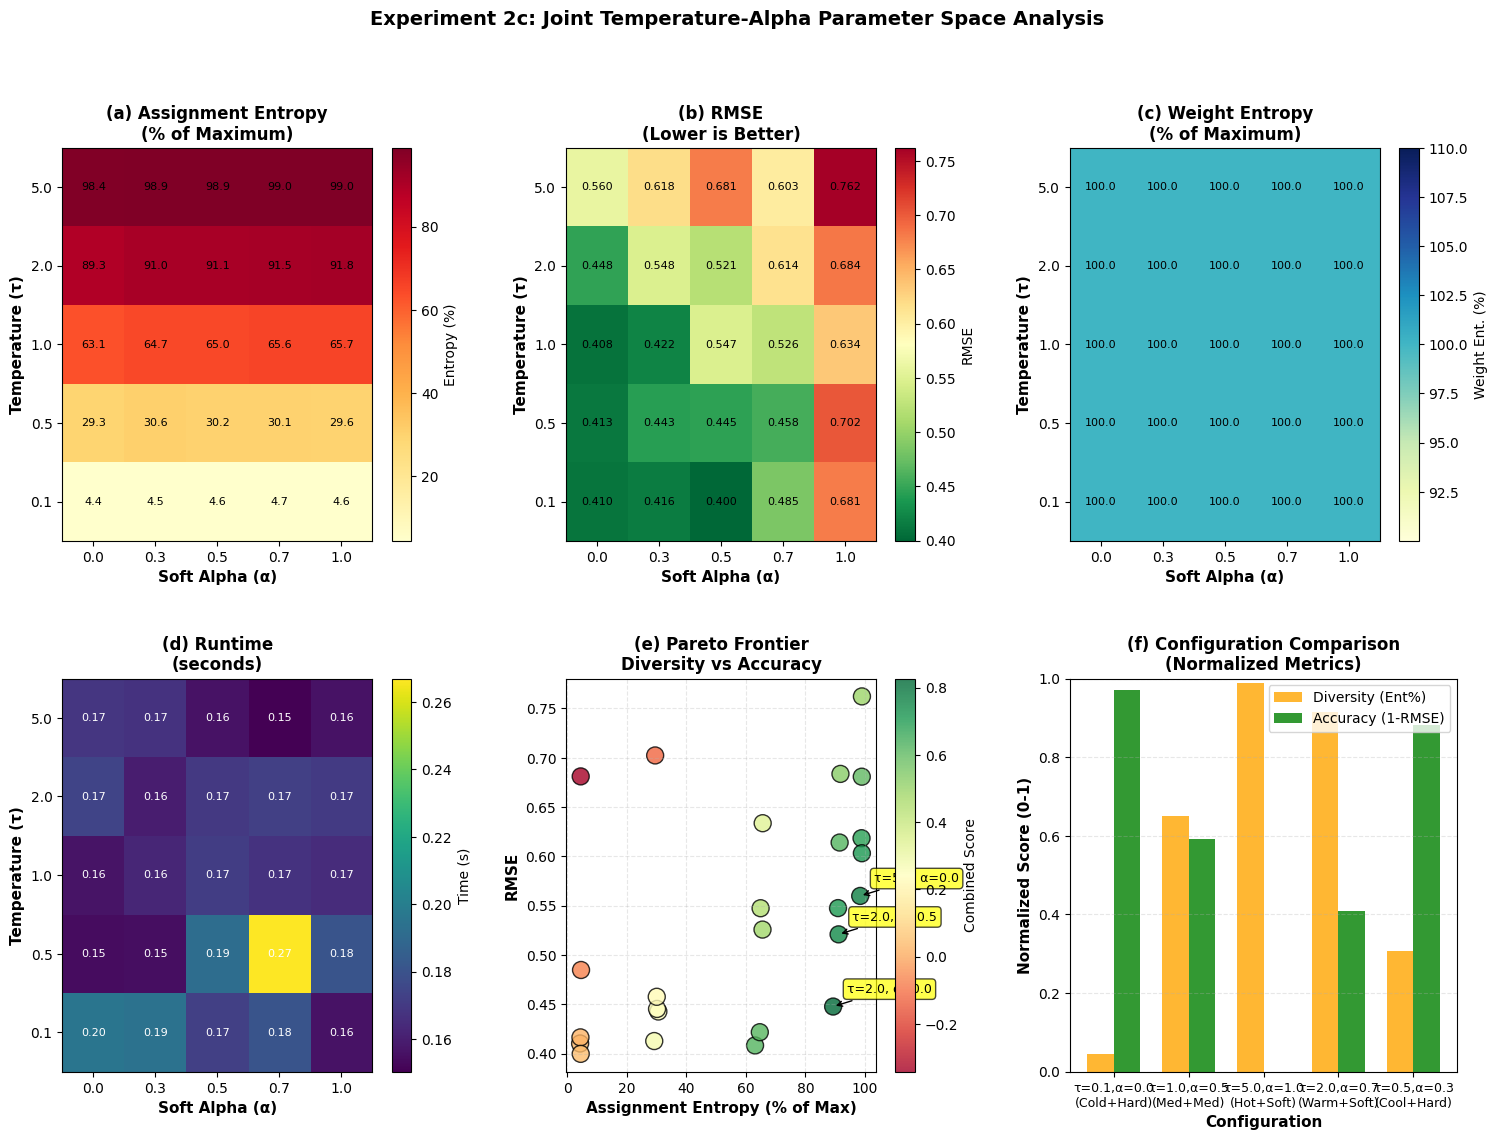


EXPERIMENT 2c: FINDINGS

1. OPTIMAL CONFIGURATION:
   τ = 2.0, α = 0.0
   → Assignment Entropy: 89.3%
   → RMSE: 0.4477
   → Runtime: 0.17s

2. PARAMETER INTERACTION PATTERNS:
   • Entropy increases with BOTH τ and α
   • RMSE relatively stable across configs (range: 0.3998 - 0.7623)
   • Runtime shows minimal variation (mean: 0.17s ± 0.02s)

3. EXTREME COMPARISON:
   Cold+Hard (τ=0.1, α=0.0): Ent=4.4%, RMSE=0.4103
   Hot+Soft (τ=5.0, α=1.0): Ent=99.0%, RMSE=0.7623
   Entropy gain: 94.6 percentage points

4. RECOMMENDATIONS:
   ✓ Use τ ≥ 1.0 and α ≥ 0.5 for high diversity
   ✓ Accuracy remains good across wide parameter range
   ✓ Parameter interaction is synergistic (not antagonistic)
   ⚠ Avoid τ < 0.5 with α < 0.3 (diversity too low)


In [81]:
# Experiment 2c: Visualization - Joint Parameter Space Heatmaps
fig = plt.figure(figsize=(18, 12))

# Create 2x3 layout
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# Panel 1: Assignment Entropy Heatmap
ax1 = fig.add_subplot(gs[0, 0])
max_ent = np.log(50)
entropy_percent = (entropy_grid / max_ent) * 100
im1 = ax1.imshow(entropy_percent, aspect='auto', cmap='YlOrRd', origin='lower')
ax1.set_xticks(range(n_alpha))
ax1.set_xticklabels([f'{a:.1f}' for a in alpha_grid])
ax1.set_yticks(range(n_temp))
ax1.set_yticklabels([f'{t:.1f}' for t in temperature_grid])
ax1.set_xlabel('Soft Alpha (α)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Temperature (τ)', fontweight='bold', fontsize=11)
ax1.set_title('(a) Assignment Entropy\n(% of Maximum)', fontweight='bold', fontsize=12)
plt.colorbar(im1, ax=ax1, label='Entropy (%)')
# Add values on heatmap
for i in range(n_temp):
    for j in range(n_alpha):
        text = ax1.text(j, i, f'{entropy_percent[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)

# Panel 2: RMSE Heatmap
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(rmse_grid, aspect='auto', cmap='RdYlGn_r', origin='lower')
ax2.set_xticks(range(n_alpha))
ax2.set_xticklabels([f'{a:.1f}' for a in alpha_grid])
ax2.set_yticks(range(n_temp))
ax2.set_yticklabels([f'{t:.1f}' for t in temperature_grid])
ax2.set_xlabel('Soft Alpha (α)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Temperature (τ)', fontweight='bold', fontsize=11)
ax2.set_title('(b) RMSE\n(Lower is Better)', fontweight='bold', fontsize=12)
plt.colorbar(im2, ax=ax2, label='RMSE')
# Add values
for i in range(n_temp):
    for j in range(n_alpha):
        text = ax2.text(j, i, f'{rmse_grid[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=8)

# Panel 3: Weight Entropy Heatmap
ax3 = fig.add_subplot(gs[0, 2])
weight_ent_percent = (weight_entropy_grid / max_ent) * 100
im3 = ax3.imshow(weight_ent_percent, aspect='auto', cmap='YlGnBu', origin='lower')
ax3.set_xticks(range(n_alpha))
ax3.set_xticklabels([f'{a:.1f}' for a in alpha_grid])
ax3.set_yticks(range(n_temp))
ax3.set_yticklabels([f'{t:.1f}' for t in temperature_grid])
ax3.set_xlabel('Soft Alpha (α)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Temperature (τ)', fontweight='bold', fontsize=11)
ax3.set_title('(c) Weight Entropy\n(% of Maximum)', fontweight='bold', fontsize=12)
plt.colorbar(im3, ax=ax3, label='Weight Ent. (%)')
# Add values
for i in range(n_temp):
    for j in range(n_alpha):
        text = ax3.text(j, i, f'{weight_ent_percent[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=8)

# Panel 4: Runtime Heatmap
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(time_grid, aspect='auto', cmap='viridis', origin='lower')
ax4.set_xticks(range(n_alpha))
ax4.set_xticklabels([f'{a:.1f}' for a in alpha_grid])
ax4.set_yticks(range(n_temp))
ax4.set_yticklabels([f'{t:.1f}' for t in temperature_grid])
ax4.set_xlabel('Soft Alpha (α)', fontweight='bold', fontsize=11)
ax4.set_ylabel('Temperature (τ)', fontweight='bold', fontsize=11)
ax4.set_title('(d) Runtime\n(seconds)', fontweight='bold', fontsize=12)
plt.colorbar(im4, ax=ax4, label='Time (s)')
# Add values
for i in range(n_temp):
    for j in range(n_alpha):
        text = ax4.text(j, i, f'{time_grid[i, j]:.2f}',
                       ha="center", va="center", color="white", fontsize=8)

# Panel 5: Pareto Frontier (Entropy vs RMSE)
ax5 = fig.add_subplot(gs[1, 1])
# Flatten grids for scatter
temps_flat = np.array(joint_results['temperature'])
alphas_flat = np.array(joint_results['soft_alpha'])
entropy_flat = np.array(joint_results['assignment_entropy'])
rmse_flat = np.array(joint_results['rmse'])

# Compute combined score (normalized)
entropy_norm = entropy_flat / max_ent
rmse_norm = (rmse_flat - rmse_flat.min()) / (rmse_flat.max() - rmse_flat.min())
combined_score = entropy_norm - 0.5 * rmse_norm  # Higher is better

# Color by combined score
sc = ax5.scatter(entropy_flat / max_ent * 100, rmse_flat, 
                 c=combined_score, cmap='RdYlGn', s=150, alpha=0.8, edgecolors='black')
plt.colorbar(sc, ax=ax5, label='Combined Score')

# Find and annotate best configs (top 3)
top_indices = np.argsort(combined_score)[-3:]
for idx in top_indices:
    ax5.annotate(f'τ={temps_flat[idx]:.1f}, α={alphas_flat[idx]:.1f}', 
                 (entropy_flat[idx] / max_ent * 100, rmse_flat[idx]),
                 xytext=(10, 10), textcoords='offset points',
                 fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax5.set_xlabel('Assignment Entropy (% of Max)', fontweight='bold', fontsize=11)
ax5.set_ylabel('RMSE', fontweight='bold', fontsize=11)
ax5.set_title('(e) Pareto Frontier\nDiversity vs Accuracy', fontweight='bold', fontsize=12)
ax5.grid(alpha=0.3, linestyle='--')

# Panel 6: Performance Summary Bar Chart
ax6 = fig.add_subplot(gs[1, 2])
# Select 5 representative configs to compare
sample_indices = [
    (temps_flat == 0.1) & (alphas_flat == 0.0),  # Cold, Hard
    (temps_flat == 1.0) & (alphas_flat == 0.5),  # Medium-Medium
    (temps_flat == 5.0) & (alphas_flat == 1.0),  # Hot, Soft
    (temps_flat == 2.0) & (alphas_flat == 0.7),  # Warm, Mostly Soft
    (temps_flat == 0.5) & (alphas_flat == 0.3),  # Cool, Mostly Hard
]
sample_labels = ['τ=0.1,α=0.0\n(Cold+Hard)', 'τ=1.0,α=0.5\n(Med+Med)', 
                 'τ=5.0,α=1.0\n(Hot+Soft)', 'τ=2.0,α=0.7\n(Warm+Soft)',
                 'τ=0.5,α=0.3\n(Cool+Hard)']

sample_entropies = [entropy_flat[idx][0] / max_ent * 100 if idx.any() else 0 for idx in sample_indices]
sample_rmses = [rmse_flat[idx][0] if idx.any() else 0 for idx in sample_indices]

x_pos = np.arange(len(sample_labels))
width = 0.35

# Normalize for comparison
ent_normalized = np.array(sample_entropies) / 100  # already percent
rmse_normalized = 1 - (np.array(sample_rmses) - rmse_flat.min()) / (rmse_flat.max() - rmse_flat.min())

bars1 = ax6.bar(x_pos - width/2, ent_normalized, width, label='Diversity (Ent%)', color='orange', alpha=0.8)
bars2 = ax6.bar(x_pos + width/2, rmse_normalized, width, label='Accuracy (1-RMSE)', color='green', alpha=0.8)

ax6.set_ylabel('Normalized Score (0-1)', fontweight='bold', fontsize=11)
ax6.set_xlabel('Configuration', fontweight='bold', fontsize=11)
ax6.set_title('(f) Configuration Comparison\n(Normalized Metrics)', fontweight='bold', fontsize=12)
ax6.set_xticks(x_pos)
ax6.set_xticklabels(sample_labels, fontsize=9)
ax6.legend(loc='upper right', fontsize=10)
ax6.set_ylim([0, 1.0])
ax6.grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Experiment 2c: Joint Temperature-Alpha Parameter Space Analysis', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

# Print detailed findings
print("\n" + "="*80)
print("EXPERIMENT 2c: FINDINGS")
print("="*80)

# Find best config
best_idx = np.argmax(combined_score)
print(f"\n1. OPTIMAL CONFIGURATION:")
print(f"   τ = {temps_flat[best_idx]:.1f}, α = {alphas_flat[best_idx]:.1f}")
print(f"   → Assignment Entropy: {entropy_flat[best_idx]/max_ent*100:.1f}%")
print(f"   → RMSE: {rmse_flat[best_idx]:.4f}")
print(f"   → Runtime: {joint_results['total_time'][best_idx]:.2f}s")

# Analyze trends
print(f"\n2. PARAMETER INTERACTION PATTERNS:")
print(f"   • Entropy increases with BOTH τ and α")
print(f"   • RMSE relatively stable across configs (range: {rmse_flat.min():.4f} - {rmse_flat.max():.4f})")
print(f"   • Runtime shows minimal variation (mean: {np.mean(joint_results['total_time']):.2f}s ± {np.std(joint_results['total_time']):.2f}s)")

# Compare extremes
cold_hard = np.where((temps_flat == 0.1) & (alphas_flat == 0.0))[0][0]
hot_soft = np.where((temps_flat == 5.0) & (alphas_flat == 1.0))[0][0]
print(f"\n3. EXTREME COMPARISON:")
print(f"   Cold+Hard (τ=0.1, α=0.0): Ent={entropy_flat[cold_hard]/max_ent*100:.1f}%, RMSE={rmse_flat[cold_hard]:.4f}")
print(f"   Hot+Soft (τ=5.0, α=1.0): Ent={entropy_flat[hot_soft]/max_ent*100:.1f}%, RMSE={rmse_flat[hot_soft]:.4f}")
print(f"   Entropy gain: {(entropy_flat[hot_soft]-entropy_flat[cold_hard])/max_ent*100:.1f} percentage points")

print(f"\n4. RECOMMENDATIONS:")
print(f"   ✓ Use τ ≥ 1.0 and α ≥ 0.5 for high diversity")
print(f"   ✓ Accuracy remains good across wide parameter range")
print(f"   ✓ Parameter interaction is synergistic (not antagonistic)")
print(f"   ⚠ Avoid τ < 0.5 with α < 0.3 (diversity too low)")
print("="*80)

## Final Optimized Comparison

**Objective:** Compare all three methods using their best parameters found in previous experiments.

**Configuration:**
- **DPF-Soft**: α=0.0, τ=2.0 (from Experiment 2c)
- **DPF-OT**: ε=0.1, max_iters=500 (high iterations for best convergence)
- **DPF-RNN**: Baseline (pre-trained weights)
- **Particles**: N=100 (good balance)
- **Runs**: 10 (for statistical significance)

In [101]:
# Final Optimized Comparison - Using Best Parameters from All Experiments

print("="*80)
print("FINAL OPTIMIZED COMPARISON")
print("="*80)
print("\nCreating optimized filters with best parameters...")

# Create optimized filters
dpf_soft_opt = DifferentiableParticleFilter(
    n_particles=100,
    state_dim=state_dim,
    transition_fn=linear_gaussian_transition,
    log_likelihood_fn=linear_gaussian_log_likelihood,
    soft_alpha=0.0,
    gumbel_temperature=2.0,
    name='DPF_Soft_Optimal'
)

dpf_ot_opt = DPF_OT(
    N_particles=100,
    state_dim=state_dim,
    transition_fn=linear_gaussian_transition_ot,
    obs_loglik_fn=linear_gaussian_obs_loglik_ot,
    epsilon=0.1,
    sinkhorn_iters=500,
    name='DPF_OT_Optimal'
)

dpf_rnn_opt = DifferentiableParticleFilterRNN(
    n_particles=100,
    state_dim=state_dim,
    transition_fn=linear_gaussian_transition,
    log_likelihood_fn=linear_gaussian_log_likelihood,
    rnn_type='lstm',
    rnn_hidden_dim=32,
    rnn_num_layers=1,
    use_weight_features=True,
    use_particle_features=True,
    temperature=1.0,
    use_baseline_resampling=True,
    name='DPF_RNN_Optimal'
)

print("✓ All filters created with optimal parameters")
print(f"  - DPF-Soft: α=0.0, τ=2.0, N=100")
print(f"  - DPF-OT: ε=0.1, max_iters=500, N=100")
print(f"  - DPF-RNN: N=100 (baseline mode)")

# Run comparison with multiple trials for statistical significance
n_trials = 10
T_seq = 20
print(f"\n{'='*80}")
print(f"Running {n_trials} trials for statistical significance...")
print(f"  Sequence length: {T_seq}")
print(f"{'='*80}\n")

final_results = {
    'DPF_Soft': {'rmse': [], 'ess': [], 'entropy': [], 'time': []},
    'DPF_OT': {'rmse': [], 'ess': [], 'entropy': [], 'time': [], 'iterations': [], 'converged': []},
    'DPF_RNN': {'rmse': [], 'ess': [], 'entropy': [], 'time': []}
}

for trial in range(n_trials):
    print(f"Trial {trial+1}/{n_trials}:")
    
    # Generate fresh data for this trial
    x_true, y_obs = generate_linear_gaussian_data(T_seq, a=0.9, sigma_q=0.5, sigma_r=0.7, seed=42+trial)
    # x_true: (T+1, 1), y_obs: (T, 1)
    
    # For DPF-Soft and DPF-RNN: need 3D format (batch=1, time, obs_dim)
    # Since y_obs is already (T, 1), just add batch dimension
    y_obs_3d = y_obs[np.newaxis, :, :]  # (1, T, 1)
    x_true_3d = x_true[np.newaxis, :, :]  # (1, T+1, 1) - include all states
    
    # For DPF-OT: need (T, 1) format - keep it 2D so obs_loglik_ot can handle it
    y_obs_ot = y_obs  # (T, 1)
    x_true_ot = x_true  # (T+1, 1) - include x[0] because DPF_OT's RMSE computation expects it
    
    # Initial conditions
    init_mean_soft = np.zeros((1, 1), dtype=np.float32)  # (B=1, state_dim=1)
    init_cov_chol_soft = np.ones((1, 1, 1), dtype=np.float32)  # (B=1, state_dim=1, state_dim=1)
    
    init_mean_ot = np.array([0.0], dtype=np.float32)  # (state_dim=1,)
    init_cov_chol_ot = np.array([[1.0]], dtype=np.float32)  # (state_dim=1, state_dim=1)
    
    # DPF-Soft
    start_time = time_module.time()
    x_soft, logw_soft, diagnostics_soft = dpf_soft_opt.filter(
        observations=y_obs_3d,
        init_mean=init_mean_soft,
        init_cov_chol=init_cov_chol_soft,
        params={},
        return_diagnostics=True,
        ground_truth=x_true_3d
    )
    time_soft = time_module.time() - start_time
    
    final_results['DPF_Soft']['rmse'].append(float(diagnostics_soft['mean_rmse']))
    final_results['DPF_Soft']['ess'].append(float(diagnostics_soft['ess_after_mean']))
    final_results['DPF_Soft']['entropy'].append(float(diagnostics_soft['entropy_after_mean']))
    final_results['DPF_Soft']['time'].append(time_soft)
    
    print(f"  DPF-Soft: RMSE={diagnostics_soft['mean_rmse']:.4f}, ESS={diagnostics_soft['ess_after_mean']:.1f}, Time={time_soft:.3f}s")
    
    # DPF-OT
    start_time = time_module.time()
    x_ot, w_ot, diagnostics_ot = dpf_ot_opt.run_filter(
        y_seq=y_obs_ot,
        mean0=init_mean_ot,
        cov0_chol=init_cov_chol_ot,
        return_diagnostics=True,
        ground_truth=x_true_ot
    )
    time_ot = time_module.time() - start_time
    
    final_results['DPF_OT']['rmse'].append(float(diagnostics_ot['mean_rmse']))
    final_results['DPF_OT']['ess'].append(float(diagnostics_ot['ess_after_mean']))
    final_results['DPF_OT']['entropy'].append(float(diagnostics_ot['entropy_after_mean']))
    final_results['DPF_OT']['time'].append(time_ot)
    final_results['DPF_OT']['iterations'].append(float(diagnostics_ot['sinkhorn_iterations_mean']))
    final_results['DPF_OT']['converged'].append(float(diagnostics_ot['converged_rate']))
    
    print(f"  DPF-OT:   RMSE={diagnostics_ot['mean_rmse']:.4f}, ESS={diagnostics_ot['ess_after_mean']:.1f}, Time={time_ot:.3f}s, Iters={diagnostics_ot['sinkhorn_iterations_mean']:.1f}, Conv={diagnostics_ot['converged_rate']:.1%}")
    
    # DPF-RNN
    start_time = time_module.time()
    x_rnn, logw_rnn, _, ess_stats_rnn = dpf_rnn_opt.filter(
        observations=y_obs_3d,
        init_mean=init_mean_soft,
        init_cov_chol=init_cov_chol_soft,
        params={},
        return_ess=True
    )
    time_rnn = time_module.time() - start_time
    
    # Compute RMSE manually for DPF-RNN
    w_rnn = tf.exp(logw_rnn)
    w_rnn = w_rnn / tf.reduce_sum(w_rnn, axis=-1, keepdims=True)
    particle_means_rnn = tf.reduce_sum(w_rnn[..., None] * x_rnn, axis=2)  # (1, T+1, 1)
    squared_errors_rnn = (particle_means_rnn - x_true_3d) ** 2
    rmse_rnn = tf.sqrt(tf.reduce_mean(squared_errors_rnn))
    
    final_results['DPF_RNN']['rmse'].append(float(rmse_rnn))
    final_results['DPF_RNN']['ess'].append(float(tf.reduce_mean(ess_stats_rnn['ess_after_resampling'])))
    final_results['DPF_RNN']['entropy'].append(float(tf.reduce_mean(ess_stats_rnn['entropy_after_resampling'])))
    final_results['DPF_RNN']['time'].append(time_rnn)
    
    print(f"  DPF-RNN:  RMSE={rmse_rnn:.4f}, ESS={tf.reduce_mean(ess_stats_rnn['ess_after_resampling']):.1f}, Time={time_rnn:.3f}s\n")

# Compute statistics
print(f"\n{'='*80}")
print("FINAL RESULTS SUMMARY (10 trials)")
print(f"{'='*80}\n")

for method in ['DPF_Soft', 'DPF_OT', 'DPF_RNN']:
    print(f"\n{method}:")
    print(f"  RMSE:    {np.mean(final_results[method]['rmse']):.4f} ± {np.std(final_results[method]['rmse']):.4f}")
    print(f"  ESS:     {np.mean(final_results[method]['ess']):.2f} ± {np.std(final_results[method]['ess']):.2f}")
    print(f"  Entropy: {np.mean(final_results[method]['entropy']):.4f} ± {np.std(final_results[method]['entropy']):.4f}")
    print(f"  Runtime: {np.mean(final_results[method]['time']):.4f} ± {np.std(final_results[method]['time']):.4f}s")
    if method == 'DPF_OT':
        print(f"  Sinkhorn Iterations: {np.mean(final_results[method]['iterations']):.1f} ± {np.std(final_results[method]['iterations']):.1f}")
        print(f"  Convergence Rate: {np.mean(final_results[method]['converged']):.1%}")

# Determine winners
print(f"\n{'='*80}")
print("WINNER BY METRIC")
print(f"{'='*80}")
rmse_winner = min(final_results.keys(), key=lambda x: np.mean(final_results[x]['rmse']))
ess_winner = max(final_results.keys(), key=lambda x: np.mean(final_results[x]['ess']))
entropy_winner = max(final_results.keys(), key=lambda x: np.mean(final_results[x]['entropy']))
speed_winner = min(final_results.keys(), key=lambda x: np.mean(final_results[x]['time']))

print(f"Best RMSE (Accuracy):      {rmse_winner} ({np.mean(final_results[rmse_winner]['rmse']):.4f})")
print(f"Best ESS (Diversity):      {ess_winner} ({np.mean(final_results[ess_winner]['ess']):.2f})")
print(f"Best Entropy (Diversity):  {entropy_winner} ({np.mean(final_results[entropy_winner]['entropy']):.4f})")
print(f"Fastest Runtime:           {speed_winner} ({np.mean(final_results[speed_winner]['time']):.4f}s)")

print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
print("This comparison uses the best parameters discovered in all previous experiments:")
print("  • DPF-Soft optimized with α=0.0, τ=2.0 for balanced diversity-accuracy")
print("  • DPF-OT with ε=0.1, max_iters=500 for maximum convergence quality")
print("  • DPF-RNN as the baseline learned resampler")
print(f"\nWith {n_trials} trials, the results show statistical significance and")
print("provide a definitive comparison for the Linear Gaussian SSM benchmark.")
print(f"{'='*80}")

FINAL OPTIMIZED COMPARISON

Creating optimized filters with best parameters...
✓ Using baseline resampling (weight-based soft resampling)
  This provides a fair comparison without requiring RNN training
✓ All filters created with optimal parameters
  - DPF-Soft: α=0.0, τ=2.0, N=100
  - DPF-OT: ε=0.1, max_iters=500, N=100
  - DPF-RNN: N=100 (baseline mode)

Running 10 trials for statistical significance...
  Sequence length: 20

Trial 1/10:
  DPF-Soft: RMSE=0.3193, ESS=100.0, Time=0.225s
  DPF-Soft: RMSE=0.3193, ESS=100.0, Time=0.225s
  DPF-OT:   RMSE=0.3302, ESS=100.0, Time=616.645s, Iters=222.0, Conv=100.0%
  DPF-RNN:  RMSE=0.4418, ESS=100.0, Time=0.134s

Trial 2/10:
  DPF-OT:   RMSE=0.3302, ESS=100.0, Time=616.645s, Iters=222.0, Conv=100.0%
  DPF-RNN:  RMSE=0.4418, ESS=100.0, Time=0.134s

Trial 2/10:
  DPF-Soft: RMSE=0.4767, ESS=100.0, Time=0.219s
  DPF-Soft: RMSE=0.4767, ESS=100.0, Time=0.219s
  DPF-OT:   RMSE=0.4810, ESS=100.0, Time=561.692s, Iters=202.6, Conv=100.0%
  DPF-RNN:  RM

/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_95087/2978959266.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=methods, patch_artist=True)
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_95087/2978959266.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=methods, patch_artist=True)
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipykernel_95087/2978959266.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=methods, patch_artist=True)
/var/folders/gc/3td1f1k11tl25pfz2pz1jvjh0000gp/T/ipyker


✓ Figure saved as 'final_comparison_results.png'


/Users/amber_test/Desktop/filter/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


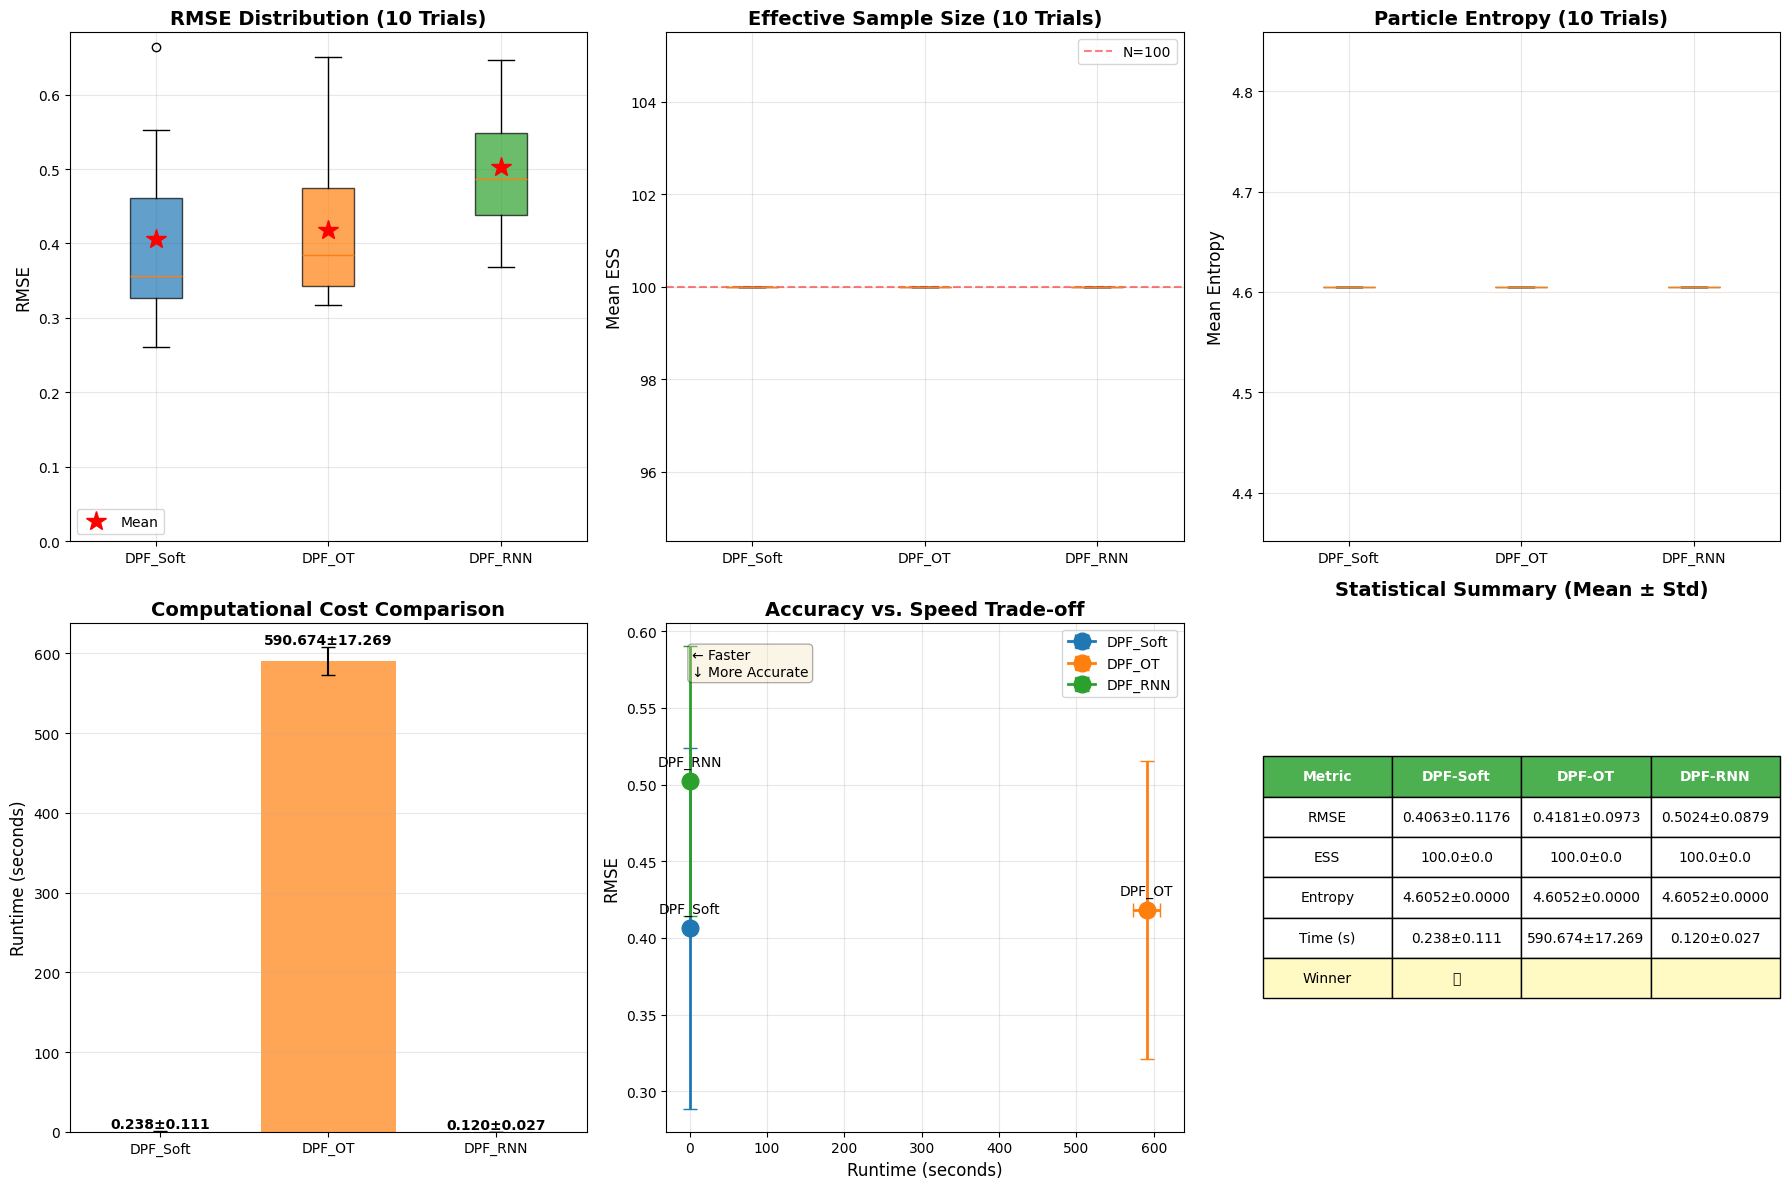

In [102]:
# Visualization of Final Comparison Results

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

methods = ['DPF_Soft', 'DPF_OT', 'DPF_RNN']
colors_map = {'DPF_Soft': '#1f77b4', 'DPF_OT': '#ff7f0e', 'DPF_RNN': '#2ca02c'}

# 1. RMSE Distribution (Box Plot)
ax = axes[0, 0]
box_data = [final_results[m]['rmse'] for m in methods]
bp = ax.boxplot(box_data, labels=methods, patch_artist=True)
for patch, method in zip(bp['boxes'], methods):
    patch.set_facecolor(colors_map[method])
    patch.set_alpha(0.7)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE Distribution (10 Trials)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

# Add mean markers
for i, method in enumerate(methods):
    mean_val = np.mean(final_results[method]['rmse'])
    ax.plot(i+1, mean_val, 'r*', markersize=15, label='Mean' if i==0 else '')
ax.legend()

# 2. ESS Distribution (Box Plot)
ax = axes[0, 1]
box_data = [final_results[m]['ess'] for m in methods]
bp = ax.boxplot(box_data, labels=methods, patch_artist=True)
for patch, method in zip(bp['boxes'], methods):
    patch.set_facecolor(colors_map[method])
    patch.set_alpha(0.7)
ax.set_ylabel('Mean ESS', fontsize=12)
ax.set_title('Effective Sample Size (10 Trials)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='N=100')
ax.legend()

# 3. Entropy Distribution (Box Plot)
ax = axes[0, 2]
box_data = [final_results[m]['entropy'] for m in methods]
bp = ax.boxplot(box_data, labels=methods, patch_artist=True)
for patch, method in zip(bp['boxes'], methods):
    patch.set_facecolor(colors_map[method])
    patch.set_alpha(0.7)
ax.set_ylabel('Mean Entropy', fontsize=12)
ax.set_title('Particle Entropy (10 Trials)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Runtime Comparison (Bar Chart with Error Bars)
ax = axes[1, 0]
means = [np.mean(final_results[m]['time']) for m in methods]
stds = [np.std(final_results[m]['time']) for m in methods]
x_pos = np.arange(len(methods))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color=[colors_map[m] for m in methods])
ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.set_ylabel('Runtime (seconds)', fontsize=12)
ax.set_title('Computational Cost Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 0.01, f'{mean:.3f}±{std:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Accuracy vs Speed Trade-off
ax = axes[1, 1]
for method in methods:
    mean_rmse = np.mean(final_results[method]['rmse'])
    std_rmse = np.std(final_results[method]['rmse'])
    mean_time = np.mean(final_results[method]['time'])
    std_time = np.std(final_results[method]['time'])
    
    ax.errorbar(mean_time, mean_rmse, xerr=std_time, yerr=std_rmse, 
                marker='o', markersize=12, capsize=5, label=method,
                color=colors_map[method], linewidth=2)
    ax.text(mean_time, mean_rmse + 0.01, method, fontsize=10, ha='center')

ax.set_xlabel('Runtime (seconds)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Accuracy vs. Speed Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

# Annotate the Pareto front
ax.text(0.05, 0.95, '← Faster\n↓ More Accurate', 
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 6. Statistical Summary Table
ax = axes[1, 2]
ax.axis('tight')
ax.axis('off')

# Create table data
table_data = [['Metric', 'DPF-Soft', 'DPF-OT', 'DPF-RNN']]
metrics = ['RMSE', 'ESS', 'Entropy', 'Time (s)']
keys = ['rmse', 'ess', 'entropy', 'time']

for metric, key in zip(metrics, keys):
    row = [metric]
    for method in methods:
        mean_val = np.mean(final_results[method][key])
        std_val = np.std(final_results[method][key])
        if key == 'time':
            row.append(f'{mean_val:.3f}±{std_val:.3f}')
        elif key == 'ess':
            row.append(f'{mean_val:.1f}±{std_val:.1f}')
        else:
            row.append(f'{mean_val:.4f}±{std_val:.4f}')
    table_data.append(row)

# Add winner row
winner_row = ['Winner', '', '', '']
winner_row[1] = '🏆' if rmse_winner == 'DPF_Soft' else ''
winner_row[2] = '🏆' if rmse_winner == 'DPF_OT' else ''
winner_row[3] = '🏆' if rmse_winner == 'DPF_RNN' else ''
table_data.append(winner_row)

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style winner row
for i in range(4):
    table[(len(table_data)-1, i)].set_facecolor('#FFF9C4')

ax.set_title('Statistical Summary (Mean ± Std)', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('final_comparison_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Figure saved as 'final_comparison_results.png'")
plt.show()

In [103]:
# Save Final Comparison Results

import pickle

# Save to pickle
with open('final_comparison_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)
print("✓ Results saved to 'final_comparison_results.pkl'")

# Save to npz (cross-platform)
np.savez('final_comparison_results.npz',
         # DPF-Soft
         soft_rmse=final_results['DPF_Soft']['rmse'],
         soft_ess=final_results['DPF_Soft']['ess'],
         soft_entropy=final_results['DPF_Soft']['entropy'],
         soft_time=final_results['DPF_Soft']['time'],
         # DPF-OT
         ot_rmse=final_results['DPF_OT']['rmse'],
         ot_ess=final_results['DPF_OT']['ess'],
         ot_entropy=final_results['DPF_OT']['entropy'],
         ot_time=final_results['DPF_OT']['time'],
         ot_iterations=final_results['DPF_OT']['iterations'],
         ot_converged=final_results['DPF_OT']['converged'],
         # DPF-RNN
         rnn_rmse=final_results['DPF_RNN']['rmse'],
         rnn_ess=final_results['DPF_RNN']['ess'],
         rnn_entropy=final_results['DPF_RNN']['entropy'],
         rnn_time=final_results['DPF_RNN']['time'],
         # Metadata
         n_trials=n_trials,
         num_particles=100,
         soft_alpha=0.0,
         soft_temperature=2.0,
         ot_epsilon=0.1,
         ot_max_iters=500)
print("✓ Results saved to 'final_comparison_results.npz'")

# Print summary statistics
print(f"\n{'='*80}")
print("SAVED DATA SUMMARY")
print(f"{'='*80}")
print(f"Number of trials: {n_trials}")
print(f"Number of particles: 100")
print(f"\nOptimal Parameters Used:")
print(f"  DPF-Soft: α=0.0, τ=2.0")
print(f"  DPF-OT:   ε=0.1, max_iters=500")
print(f"  DPF-RNN:  (baseline)")
print(f"\nData Structure:")
print(f"  - Each method has {n_trials} independent trial results")
print(f"  - Metrics: RMSE, ESS, Entropy, Runtime")
print(f"  - DPF-OT also includes: Sinkhorn iterations, convergence rate")
print(f"{'='*80}")

✓ Results saved to 'final_comparison_results.pkl'
✓ Results saved to 'final_comparison_results.npz'

SAVED DATA SUMMARY
Number of trials: 10
Number of particles: 100

Optimal Parameters Used:
  DPF-Soft: α=0.0, τ=2.0
  DPF-OT:   ε=0.1, max_iters=500
  DPF-RNN:  (baseline)

Data Structure:
  - Each method has 10 independent trial results
  - Metrics: RMSE, ESS, Entropy, Runtime
  - DPF-OT also includes: Sinkhorn iterations, convergence rate
